In [1]:
import math
import os
import datetime
import numpy as np
import pandas as pd
from pandas_datareader import data 
from sklearn.preprocessing import MinMaxScaler
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Q - 1 - 1 : Stock price prediction using RNN

In [20]:
def feature_scaling(df):
    
#     df['open'] = MinMaxScaler().fit_transform(df.open.values.reshape(-1,1))
    df['volume'] = MinMaxScaler().fit_transform(df.volume.values.reshape(-1,1))
    df['average'] = MinMaxScaler().fit_transform(df.average.values.reshape(-1,1))
    return df

In [3]:
def train_validation_split(df,time_steps = 10,split_percentage = 0.3):

     
    data = df.values
    new_data = []
    
    for index in range(data.shape[0] - time_steps): 
        new_data.append(data[index: index + time_steps])
    
    new_data = np.array(new_data)
    
    valid_set_size = int(split_percentage*data.shape[0]);  
    train_set_size = new_data.shape[0] - (valid_set_size);
    
    X_train = new_data[:train_set_size,:-1,:]
    Y_train = new_data[:train_set_size,-1,:]
    
    X_validation = new_data[train_set_size:train_set_size+valid_set_size,:-1,:]
    Y_validation = new_data[train_set_size:train_set_size+valid_set_size,-1,:]
    

    return X_train, Y_train, X_validation, Y_validation

In [4]:
def data_preprocessing(isHMM = False):

    df = pd.read_csv("GoogleStocks.csv")
    df = df.sort_values(by=['date'])
    df["average"] = (df.low + df.high)/2
#     df.drop(['high','low','close','date'],axis=1,inplace=True)
    df.drop(['high','low','close','date','open'],axis=1,inplace=True)
    
    df = feature_scaling(df)
    
    if isHMM == True:

        train_set_percentage = 0.7
        train_set_size = int(df.shape[0]*train_set_percentage)

        train_df = df.iloc[:train_set_size,:].values
        validation_df = df.iloc[train_set_size:,:].values

        return train_df, validation_df
        
    else:
        return df

In [5]:
def exploratory_data_visualization():
    df = data_preprocessing()
#     plt.plot(df.open.values, color='red', label='open')
    plt.plot(df.average.values, color='yellow', label='average')
    
    plt.title('stock price')
    plt.xlabel('time [days]')
    plt.ylabel('price')
    plt.legend(loc='best')
    plt.show()

    plt.plot(df.volume.values, color='blue', label='volume')
    plt.title('stock volume')
    plt.xlabel('time [days]')
    plt.ylabel('volume')
    plt.legend(loc='best');
    plt.show()

In [6]:
def train_evaluate_model(params):

    X_train, Y_train, X_validation, Y_validation, n_steps,n_inputs,n_neurons,n_outputs,n_layers,learning_rate,n_epochs = params
    
    tf.reset_default_graph()

    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    y = tf.placeholder(tf.float32, [None, n_outputs])

    layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.MinMaxScaler)for layer in range(n_layers)]

    multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
    rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

    stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
    stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
    outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
    outputs = outputs[:,n_steps-1,:]

    loss = tf.reduce_mean(tf.square(outputs - y)) 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
    training_op = optimizer.minimize(loss)

    # run graph
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        for epoch in range(n_epochs):
            
            sess.run(training_op, feed_dict={X: X_train, y: Y_train}) 
            
            if epoch % 10 == 0:
                mse_train = loss.eval(feed_dict={X: X_train, y:Y_train}) 
                mse_valid = loss.eval(feed_dict={X: X_validation, y: Y_validation})
                
#                 print('%d epochs: MSE train/valid = %.8f/%.8f'%(epoch, mse_train, mse_valid))

        Y_train_prediction = sess.run(outputs, feed_dict={X: X_train})
        Y_valid_prediction = sess.run(outputs, feed_dict={X: X_validation})
        
    return  Y_train_prediction, Y_valid_prediction

In [7]:
def output_visualization(Y_train,Y_validation,Y_train_prediction,Y_validation_prediction,time_steps,num_neurons,num_layers,index):
    
    plt.figure(figsize=(15, 5), dpi=100)
    
    x_length = Y_train.shape[0]
    
    plt.plot(np.arange(x_length), Y_train[:,1], color='blue', label='Train Target')

    plt.plot(np.arange(x_length, x_length + Y_validation.shape[0]), Y_validation[:,1],color='gray', label='Validation Target')

    x_length = Y_train_prediction.shape[0]
    
    plt.plot(np.arange(x_length),Y_train_prediction[:,1], color='red',label='Train Prediction')

    plt.plot(np.arange(x_length, x_length+Y_validation_prediction.shape[0]),Y_validation_prediction[:,1], color='orange', label='Valid Prediction')

     
    plt.title('Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Price (normalized)')
    plt.legend(loc='best')
    plt.show()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.



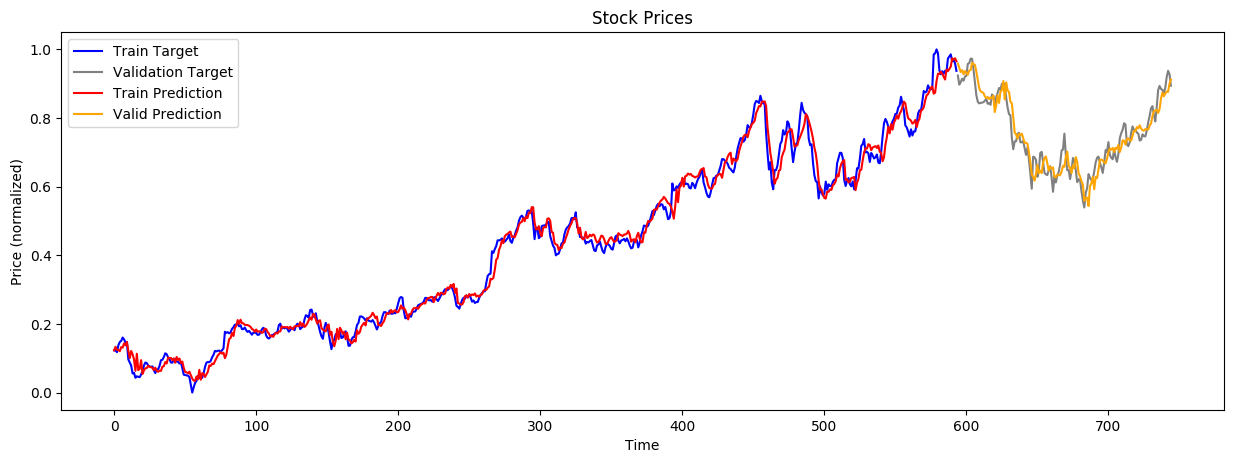

Model built with  2  layers and  30  neurons at each layer and with time steps  20
R2 Score for open price for train data 0.9881207829512217
R2 Score for open price for validation data 0.8845956804962644



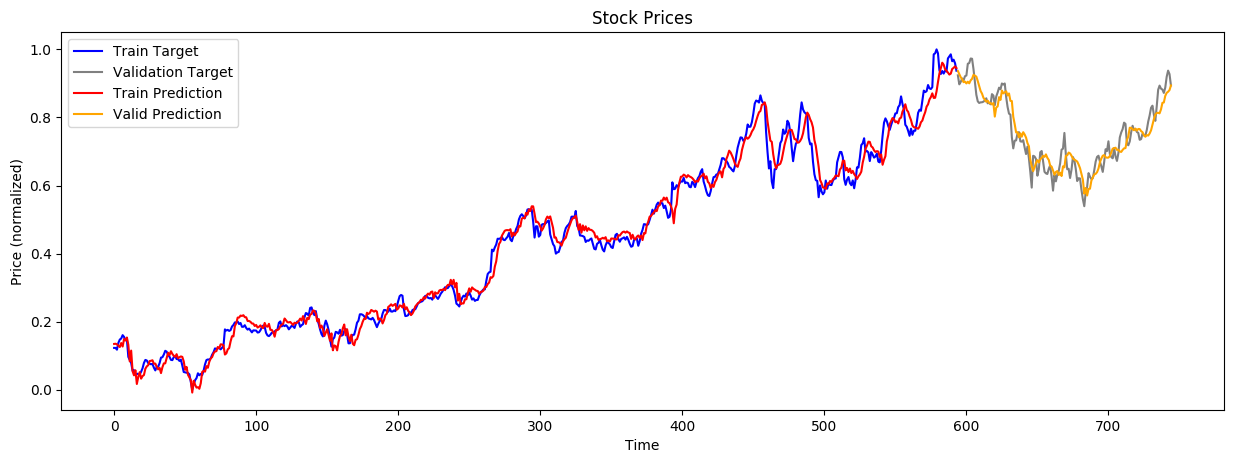

Model built with  2  layers and  30  neurons at each layer and with time steps  50
R2 Score for open price for train data 0.9831719428952908
R2 Score for open price for validation data 0.8682376454063276



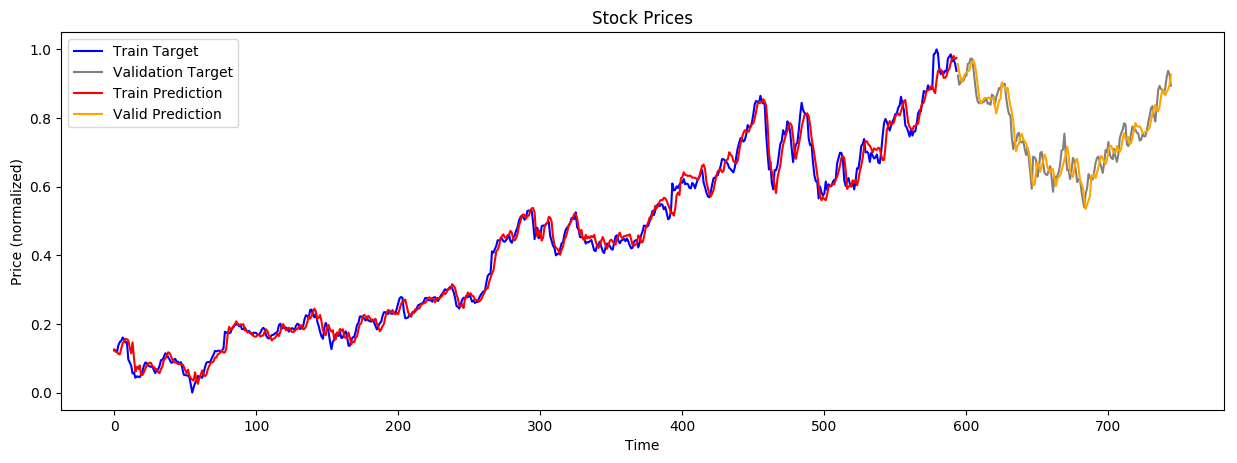

Model built with  2  layers and  30  neurons at each layer and with time steps  75
R2 Score for open price for train data 0.9892827072145358
R2 Score for open price for validation data 0.8955668514915403



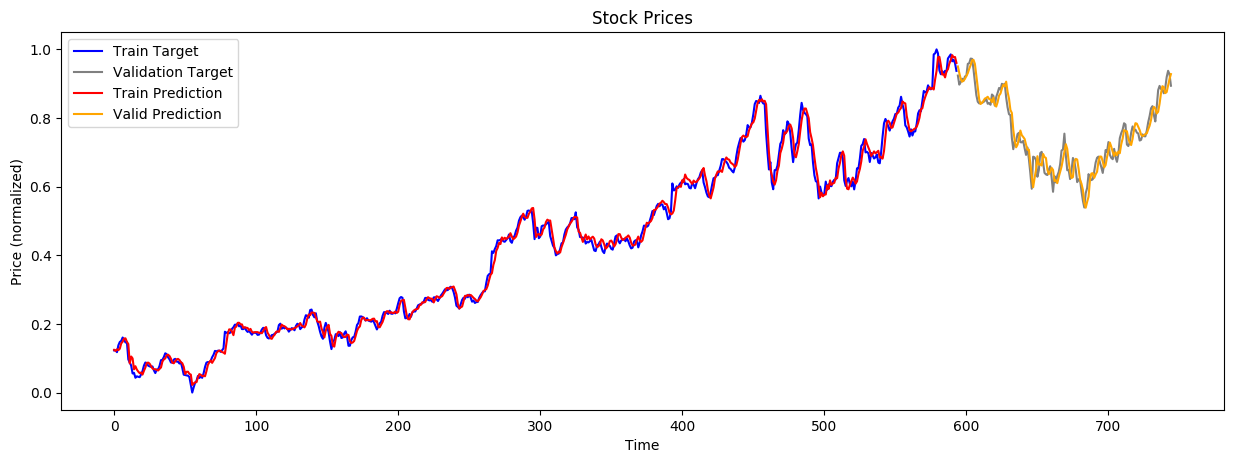

Model built with  2  layers and  50  neurons at each layer and with time steps  20
R2 Score for open price for train data 0.993322263538826
R2 Score for open price for validation data 0.9153420856778721



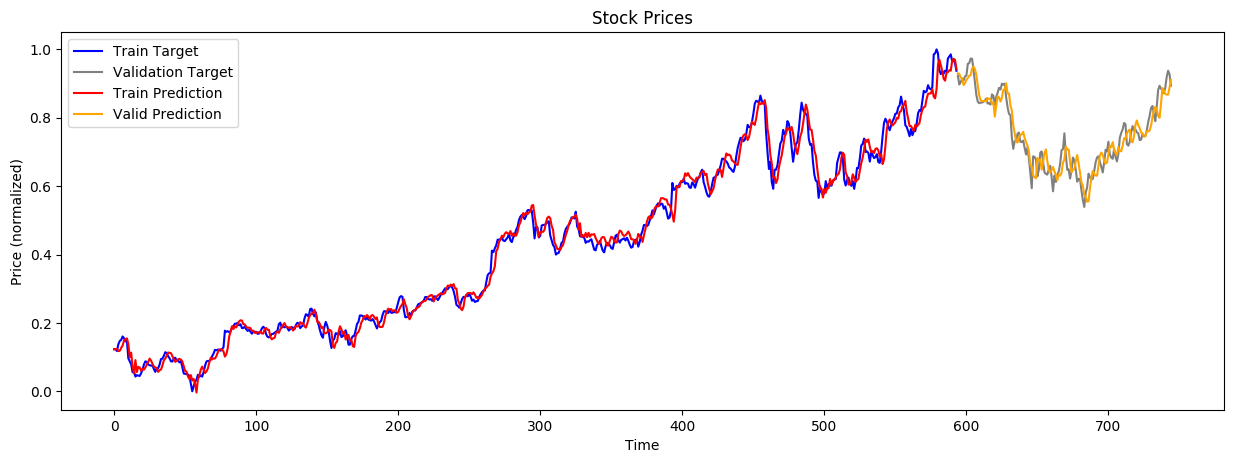

Model built with  2  layers and  50  neurons at each layer and with time steps  50
R2 Score for open price for train data 0.9883876711764217
R2 Score for open price for validation data 0.8769825570711657



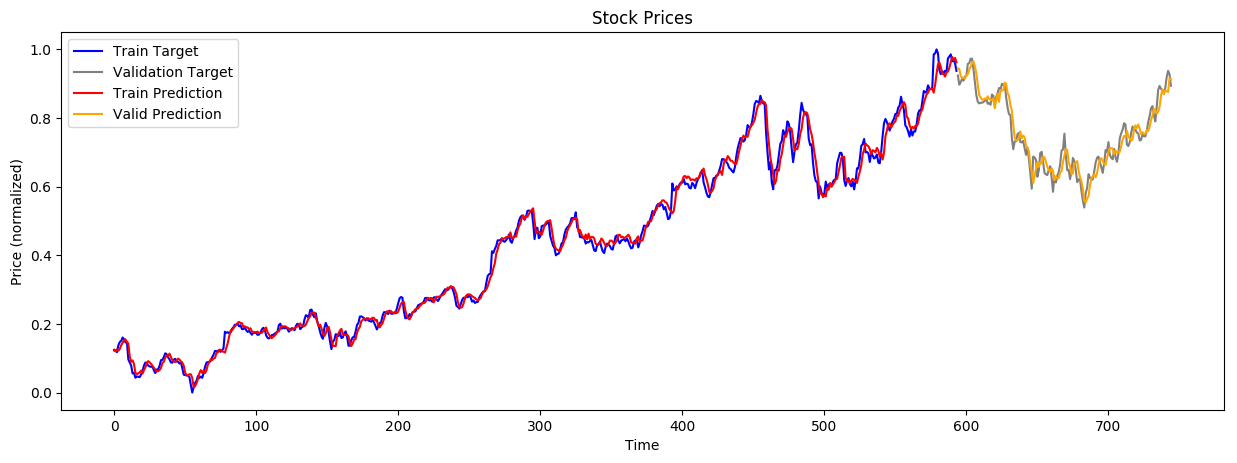

Model built with  2  layers and  50  neurons at each layer and with time steps  75
R2 Score for open price for train data 0.9921550606135146
R2 Score for open price for validation data 0.9147395296750281



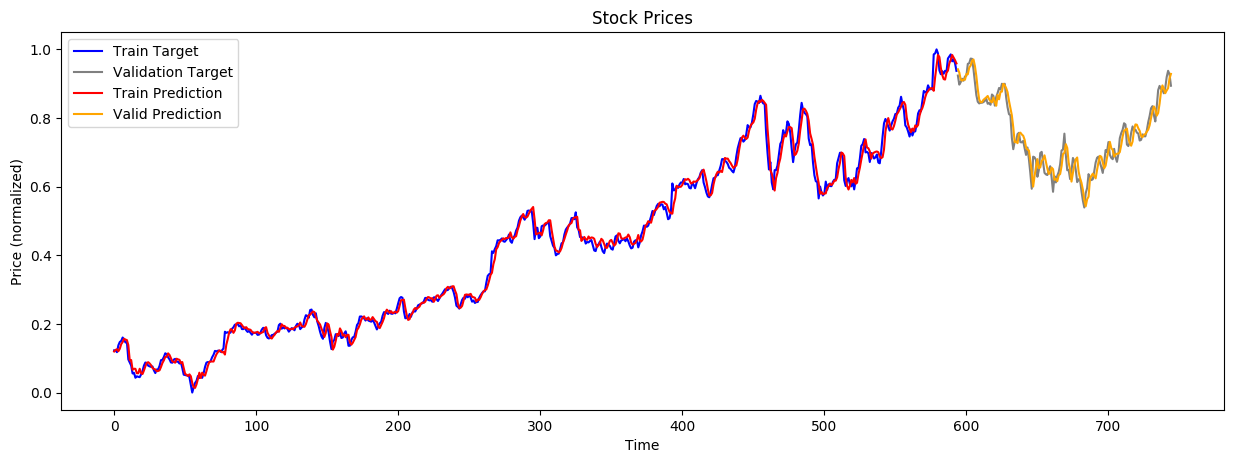

Model built with  2  layers and  80  neurons at each layer and with time steps  20
R2 Score for open price for train data 0.9935814456970854
R2 Score for open price for validation data 0.9188307800922557



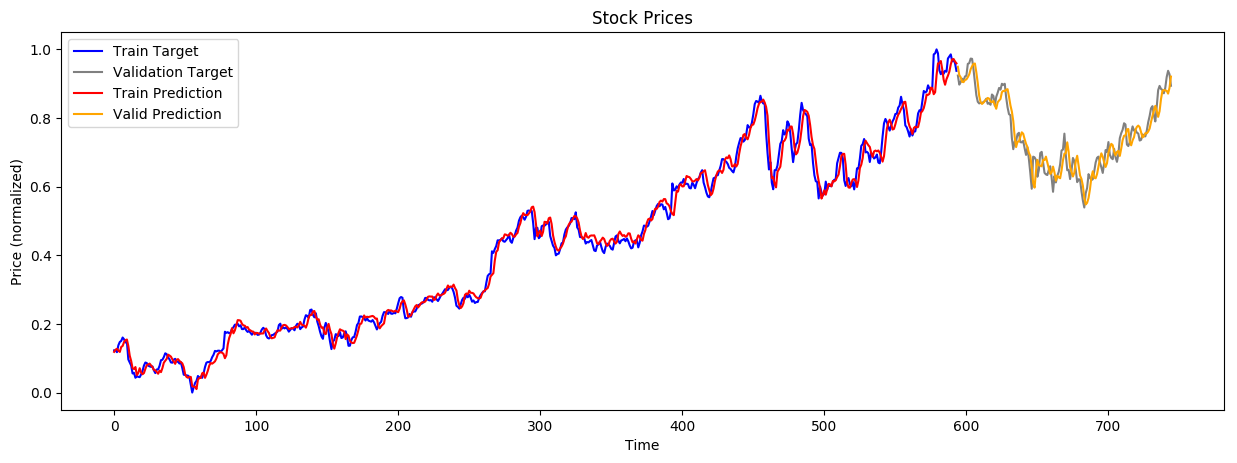

Model built with  2  layers and  80  neurons at each layer and with time steps  50
R2 Score for open price for train data 0.9895285177464684
R2 Score for open price for validation data 0.883106792918527



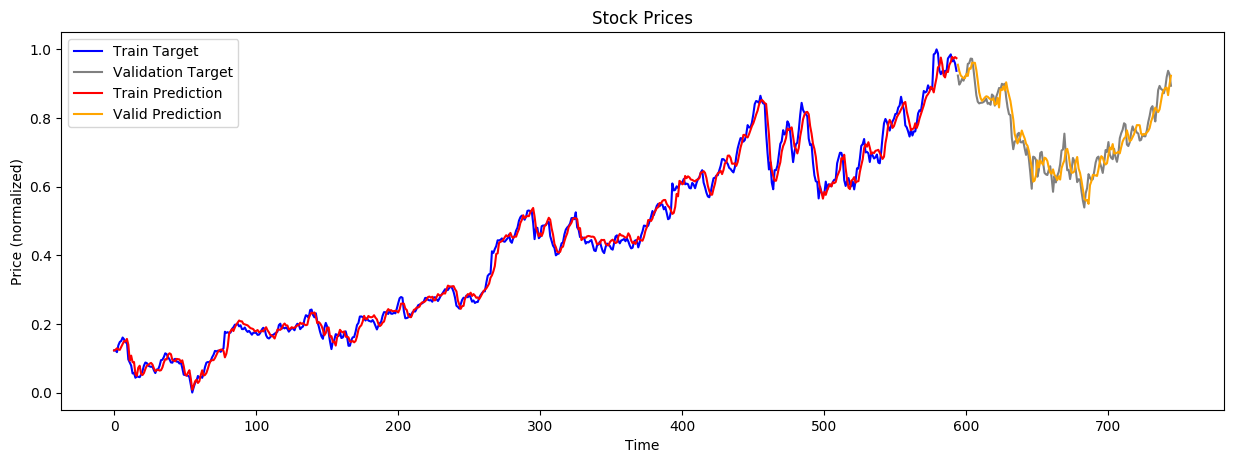

Model built with  2  layers and  80  neurons at each layer and with time steps  75
R2 Score for open price for train data 0.9901239757904313
R2 Score for open price for validation data 0.8898363824310952



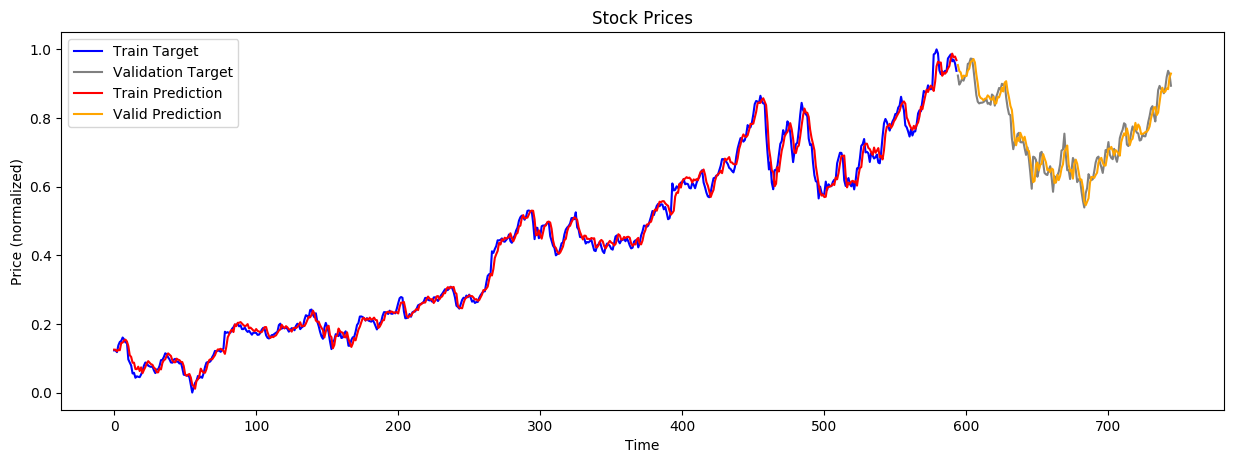

Model built with  3  layers and  30  neurons at each layer and with time steps  20
R2 Score for open price for train data 0.9924854713633818
R2 Score for open price for validation data 0.9116245797314955



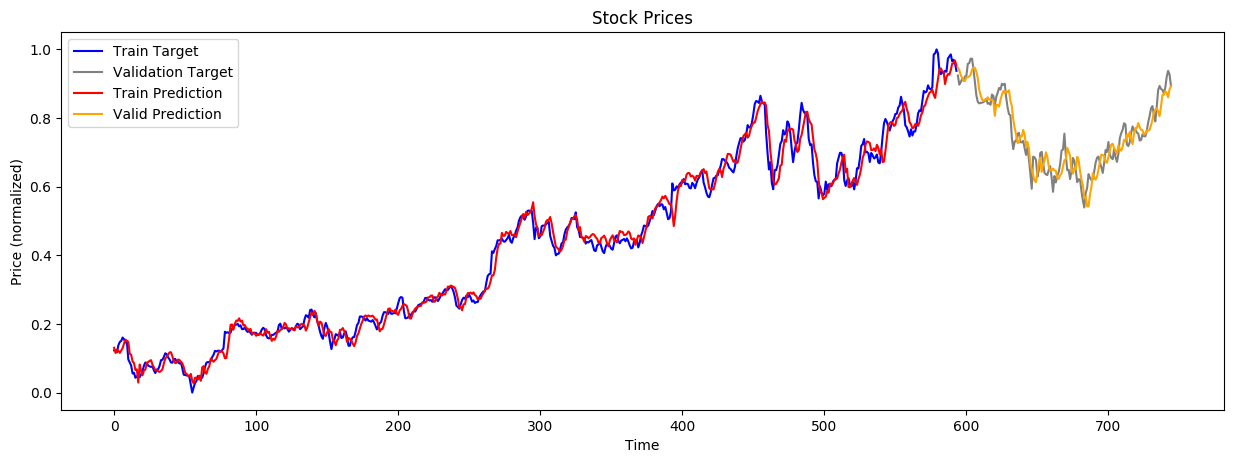

Model built with  3  layers and  30  neurons at each layer and with time steps  50
R2 Score for open price for train data 0.986120716822031
R2 Score for open price for validation data 0.8639872925878993



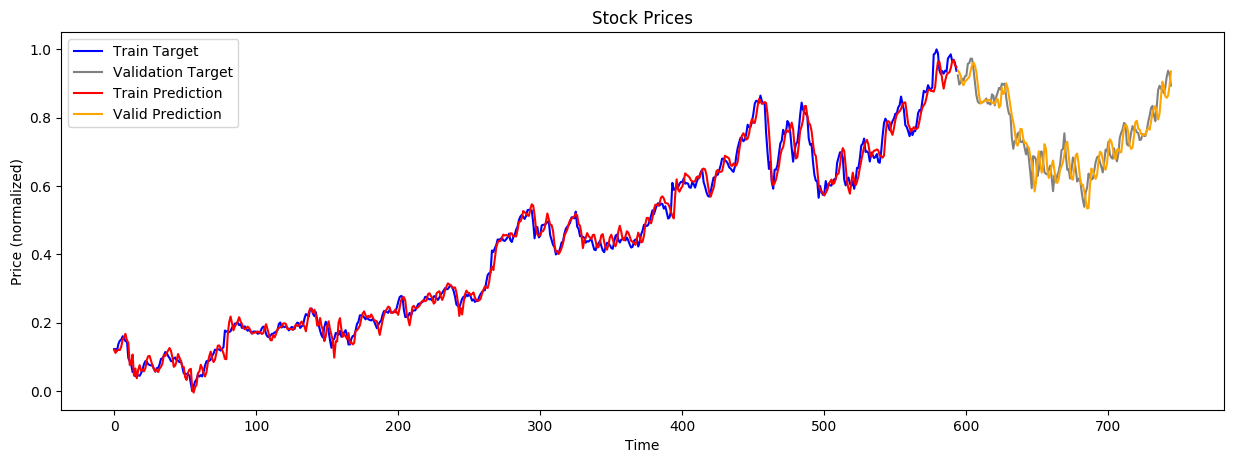

Model built with  3  layers and  30  neurons at each layer and with time steps  75
R2 Score for open price for train data 0.9893139607158442
R2 Score for open price for validation data 0.8563053817029581



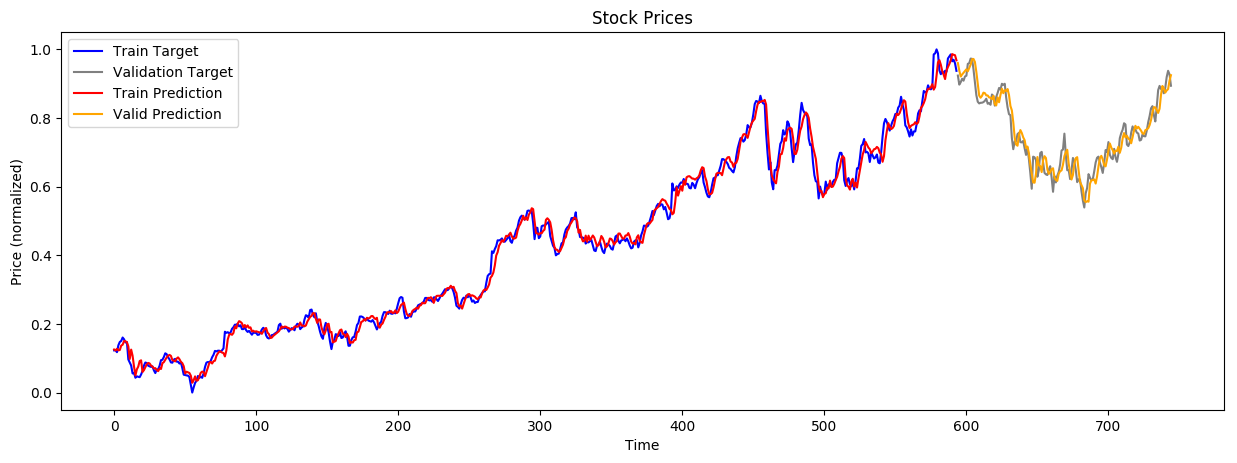

Model built with  3  layers and  50  neurons at each layer and with time steps  20
R2 Score for open price for train data 0.991466315635749
R2 Score for open price for validation data 0.898462123549469



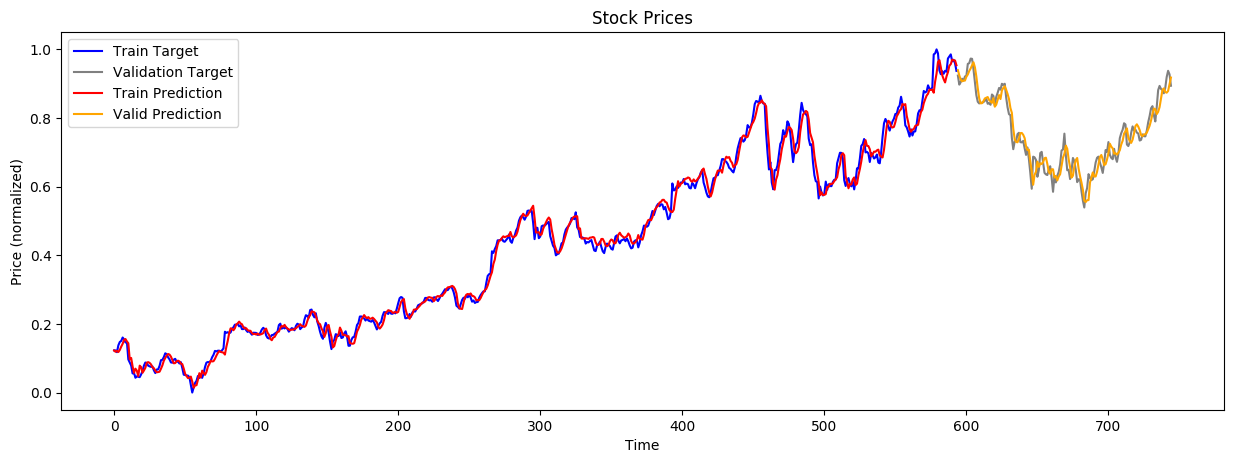

Model built with  3  layers and  50  neurons at each layer and with time steps  50
R2 Score for open price for train data 0.9925788774929258
R2 Score for open price for validation data 0.914581656557138



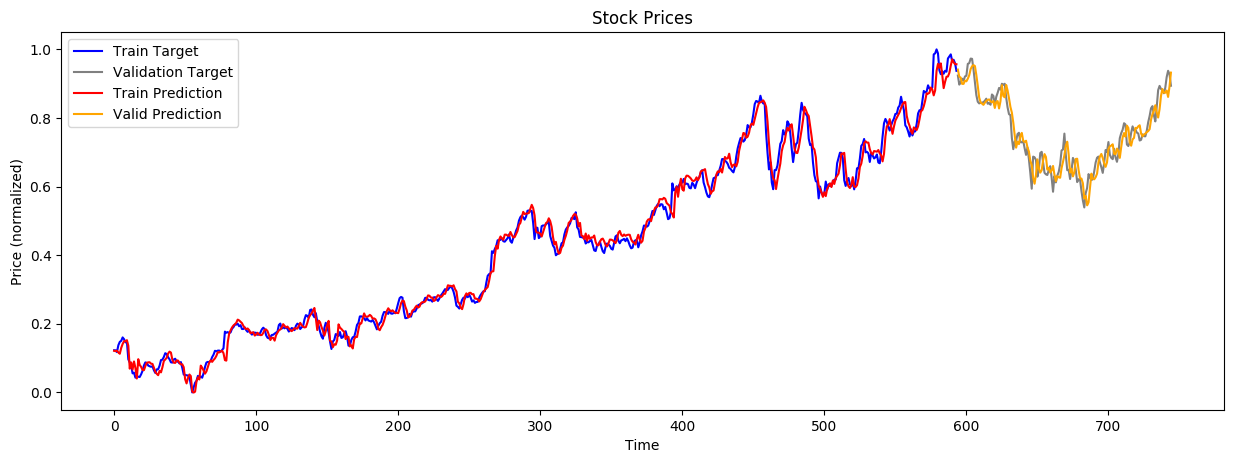

Model built with  3  layers and  50  neurons at each layer and with time steps  75
R2 Score for open price for train data 0.9900979103685562
R2 Score for open price for validation data 0.8834513289950809



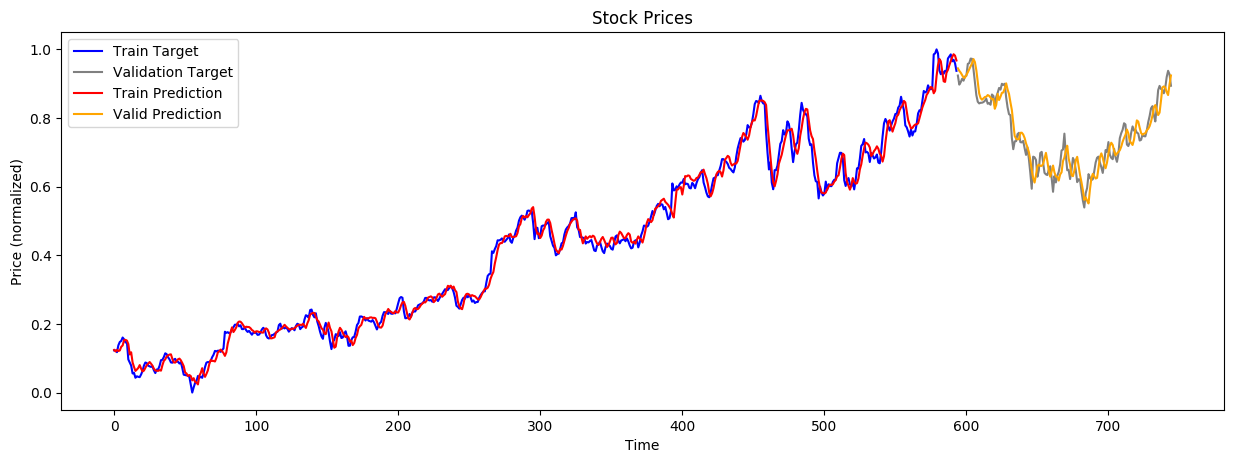

Model built with  3  layers and  80  neurons at each layer and with time steps  20
R2 Score for open price for train data 0.9902136754687078
R2 Score for open price for validation data 0.8832045297269803



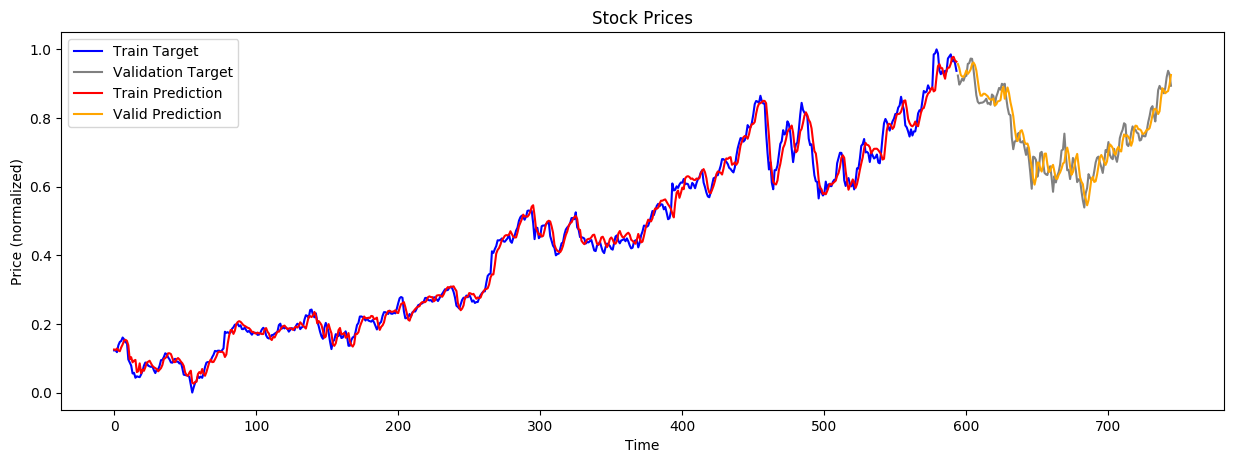

Model built with  3  layers and  80  neurons at each layer and with time steps  50
R2 Score for open price for train data 0.9894121688027799
R2 Score for open price for validation data 0.8769823579117175



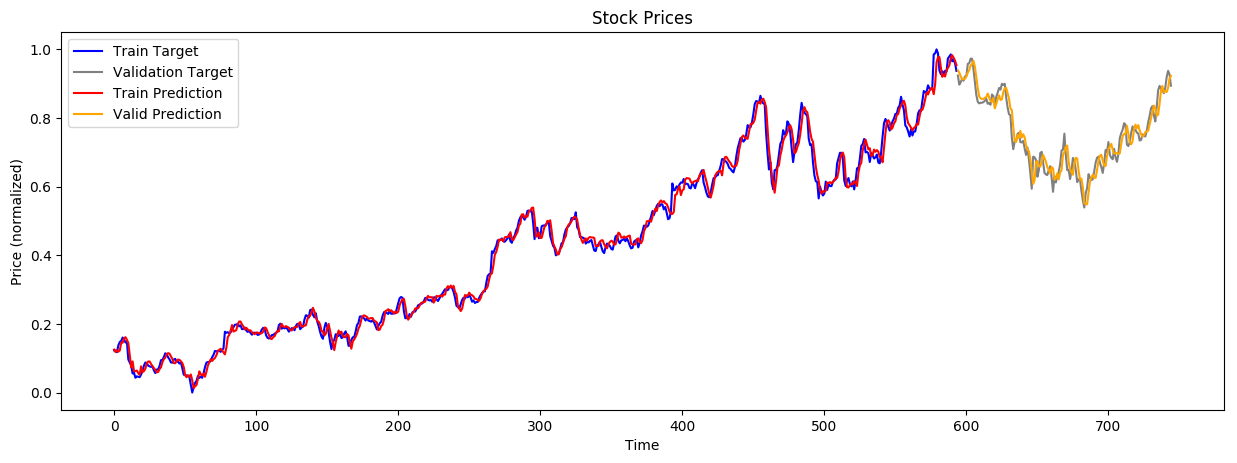

Model built with  3  layers and  80  neurons at each layer and with time steps  75
R2 Score for open price for train data 0.992877768937986
R2 Score for open price for validation data 0.912445663101945


In [9]:
time_steps = 10
num_steps = time_steps-1 
num_inputs = 2
num_neurons = 200 
num_outputs = 2
num_layers = 2
learning_rate = 0.001
num_epochs = 300

hidden_layers = [2,3]
hidden_layer_size = [30,50,80]
time_steps_list = [20,50,75]

df = data_preprocessing()

X_train, Y_train, X_validation, Y_validation = train_validation_split(df,time_steps = time_steps,split_percentage = 0.2)

accuracy_train_list = []
accuracy_valid_list = []
number_of_layers = []
number_of_neurons = []
number_of_time_steps = []

index = 1

for num_layers in hidden_layers:
    
    for num_neurons in hidden_layer_size:
        
        for time_steps in time_steps_list:
    
            params = [X_train, Y_train, X_validation, Y_validation, num_steps,num_inputs,num_neurons,num_outputs,num_layers,learning_rate,num_epochs]

            Y_train_prediction,Y_validation_prediction = train_evaluate_model(params)

            print()

            output_visualization(Y_train,Y_validation,Y_train_prediction,Y_validation_prediction,time_steps,num_neurons,num_layers,index)
            index += 1
            
            accuracy_train = r2_score(Y_train[:,1],Y_train_prediction[:,1])
            accuracy_valid = r2_score(Y_validation[:,1],Y_validation_prediction[:,1])

            accuracy_train_list.append(accuracy_train)
            accuracy_valid_list.append(accuracy_valid)
            number_of_layers.append(num_layers)
            number_of_neurons.append(num_neurons)
            number_of_time_steps.append(time_steps)
            
            print("Model built with ",num_layers," layers and ",num_neurons," neurons at each layer and with time steps ",time_steps)
            print('R2 Score for open price for train data',accuracy_train)
            print('R2 Score for open price for validation data',accuracy_valid)
            

# Q - 1 - 2 : Stock price prediction using Hidden Markov Model

In [10]:
def exploratory_data_visualization():
    X, X_validation = data_preprocessing(isHMM = True)
    plt.figure(figsize=(15, 5), dpi=100) 
    plt.title("Stock open price for Google", fontsize = 14)
    plt.plot(np.arange(X.shape[0]),X[:,1])
    plt.ylabel("Price")
    plt.xlabel("Days in increasing order")
    plt.show()

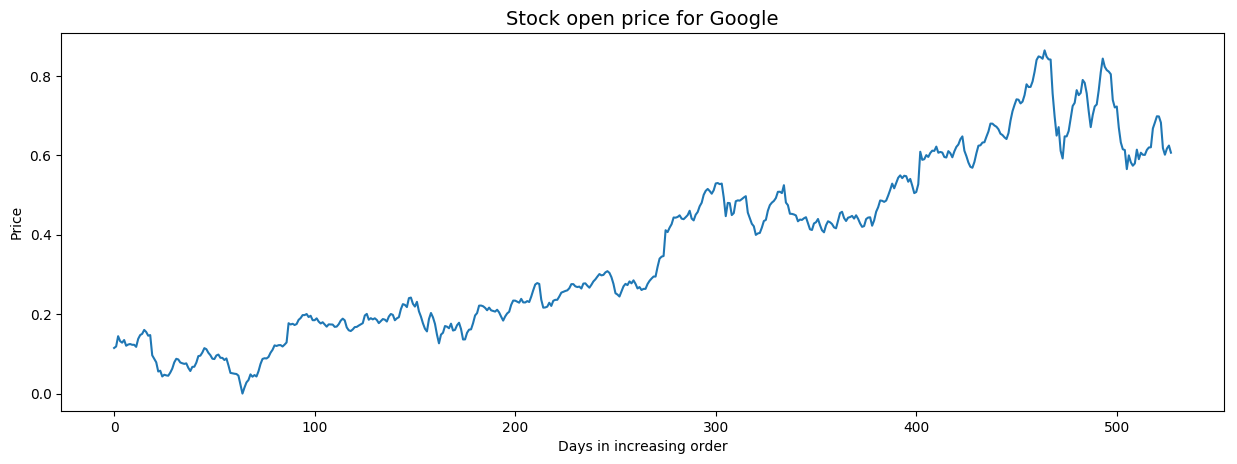

In [11]:
exploratory_data_visualization()

In [31]:
def train_model(X,params):
    n_components, covariance_type, n_iter = params 
    model = GaussianHMM(algorithm = 'viterbi',n_components=n_components, covariance_type=covariance_type, n_iter=n_iter)
    model.fit(X)
    return model

In [32]:
def model_visualization():
    
    X, X_validation = data_preprocessing(isHMM = True)
    # print(X)
    params = [15,"diag",1000]
    model = train_model(X,params)
    hidden_states = model.predict(X)

    print(hidden_states)
    print(model.monitor_)

    print("Has model converged: ",model.monitor_.converged)

    num_samples = X.shape[0]
    samples, _ = model.sample(num_samples)

    samples = MinMaxScaler().fit_transform(samples)
    open_norm = MinMaxScaler().fit_transform(X[:,1].reshape(-1,1))
    plt.figure(figsize=(20,10))
    plt.title("Stock open price for Google", fontsize = 14)
    plt.ylabel("Price (Normalized)")
    plt.xlabel("Days in increasing order")
    plt.plot(np.arange(num_samples),samples[:,1],color = 'green',label = "Generated by HMM")
    plt.plot(np.arange(num_samples),open_norm,color = 'blue',label = "Actual")
    plt.legend(loc='best')
    plt.show()

[ 3  3  3  3  3  3  3  3  3  3  3  3  6  6  6  6  6  6 13  7 11 11 11 11
 11 11 11 11 11 11  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11  3  3  3  3  3  3  3  3  3  3  3  3  3 13  7 13  6  6  6  6  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6
  6  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5 10
 10 10 10 10 10 10 13  7 13  6  6  6  6  6  6 13  7 13  7 13  6  6  6  6
  6  6  6  6  6  6 13  6  6  6  6  6  6 10 10 10 10 10  5  5  5  5  5  5
  5  5  5  5  5  5 10 10 10 10 10 10 10 10 10 10 10 10 10 13  7 13 10 10
 10 10 10 10 10 10 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0 13 10 10 10  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  4  9  4  4  4  4  4 14 14 14 14 14 14 14
  4  4 14 14 14 14  4  4  4  4  4  4  4  4  4  4  9  9  4  4  4  9  4 14
 14 14  4  4  9  9  9  4  4  4 14 14 14 14 14 14 14

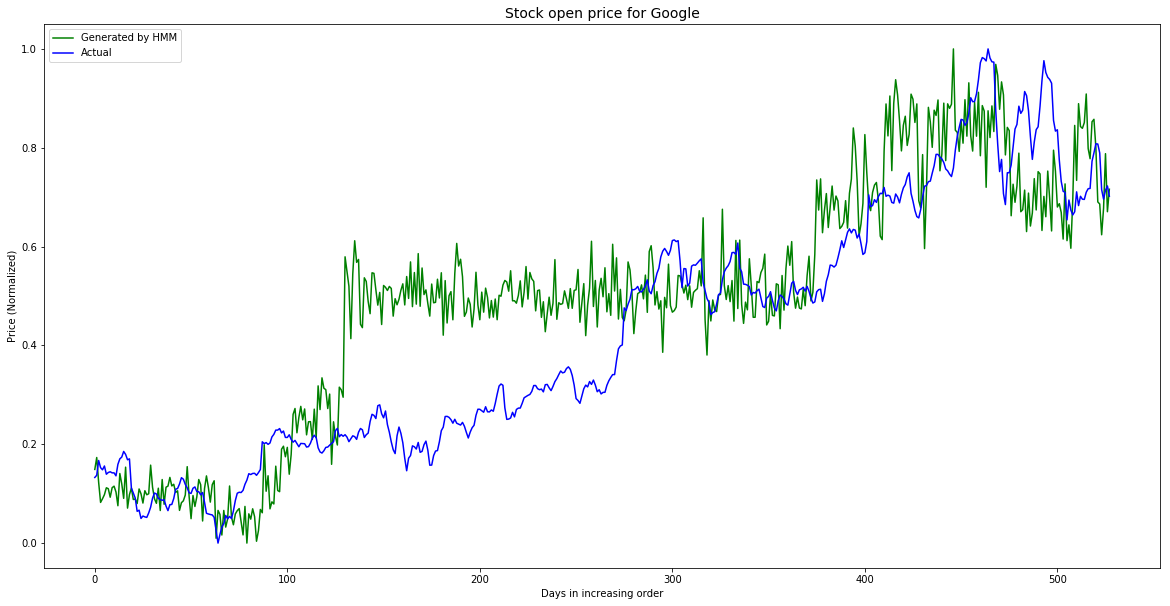

In [34]:
model_visualization()

In [41]:
def prediction(model,X,num_steps,return_prediction = False):
    
    hidden_states = model.predict(X)
#     print(model.transmat_, model.means_)
    expected_values = np.dot(model.transmat_, model.means_)
    print(expected_values)
    expected_values_columnwise = list(zip(*expected_values))
    expected_open = expected_values_columnwise[1]
    expected_volumes = expected_values_columnwise[0]
#     expected_average = expected_values_columnwise[2]
    
    predicted_open = []
    predicted_average = []
    predicted_volumes = []
    actual_volumes = []
    actual_open = []
    actual_average = []

    for i in range(num_steps):
        state = hidden_states[i]
        volume = X[i,0]
        open_val = X[i,1]
#         average = X[i,2]#[2]

        actual_volumes.append(volume)
        actual_open.append(open_val)
#         actual_average.append(average)

        predicted_open.append(expected_open[state])
        predicted_volumes.append(np.round(expected_volumes[state]))    
#         predicted_average.append(expected_average[state])

    if return_prediction == False:
        #Open
        plt.figure(figsize=(15, 5), dpi=100) 
        plt.title("Stock open price predition for Google", fontsize = 14)
        plt.plot(np.arange(num_steps),actual_open,label = "Actual")
        plt.plot(np.arange(num_steps),predicted_open, label = "Predicted")
        plt.ylabel("Price")
        plt.xlabel("Days in increasing order")
        plt.legend(loc = "best")
        plt.show()
    else: 
        return actual_open,predicted_open


Model based on number of hidden states:  4  and time steps:  20

On Train Data
[[0.16752842 0.18748746]
 [0.18902252 0.6730554 ]
 [0.16643223 0.45887599]
 [0.37168566 0.33747818]]


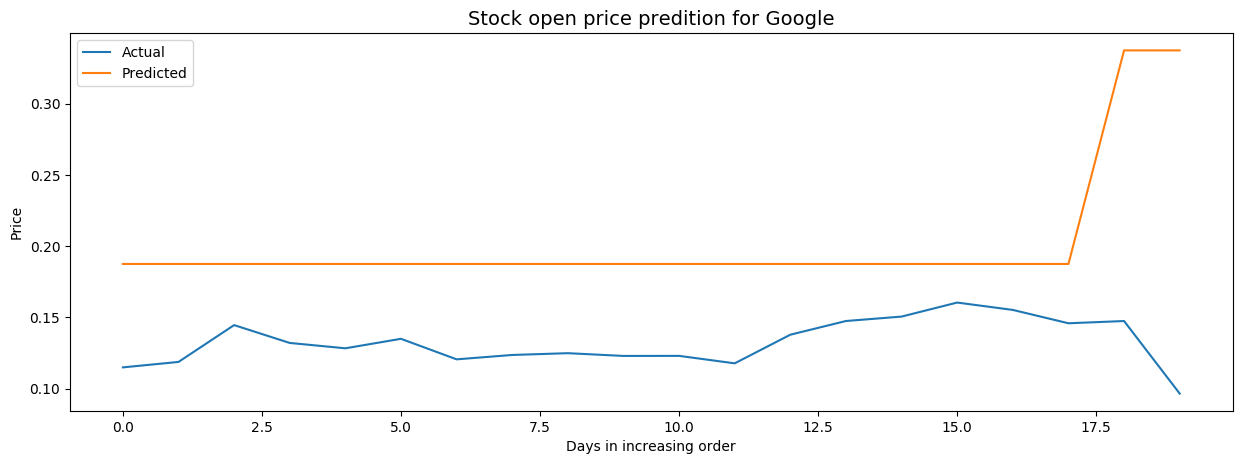


On Validation Data
[[0.16752842 0.18748746]
 [0.18902252 0.6730554 ]
 [0.16643223 0.45887599]
 [0.37168566 0.33747818]]


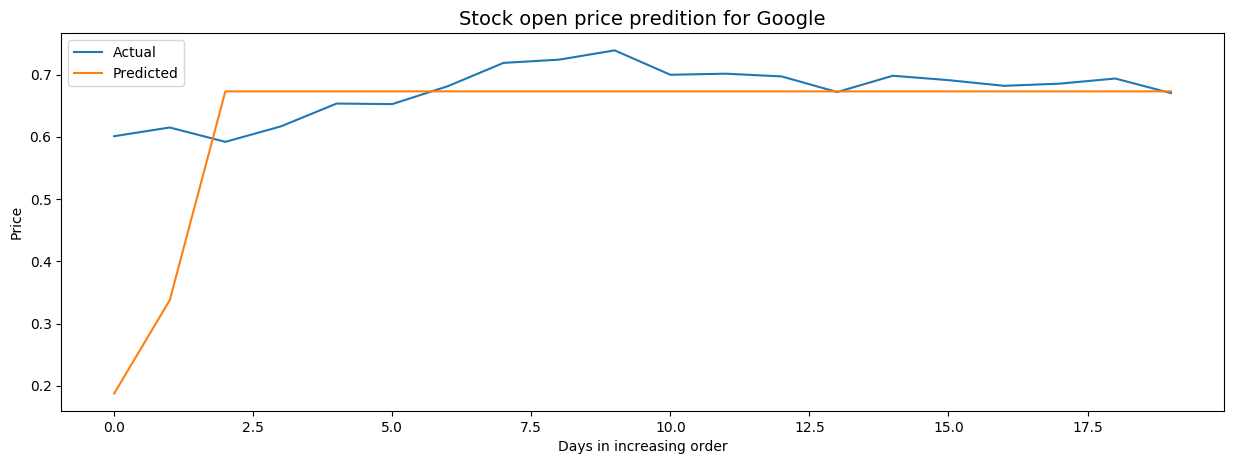



Model based on number of hidden states:  8  and time steps:  20

On Train Data
[[0.1684565  0.50652694]
 [0.18419734 0.09562098]
 [0.3311862  0.45749085]
 [0.19355674 0.76397958]
 [0.35198334 0.15566803]
 [0.15193561 0.2210738 ]
 [0.23092692 0.63015373]
 [0.15090931 0.4391776 ]]


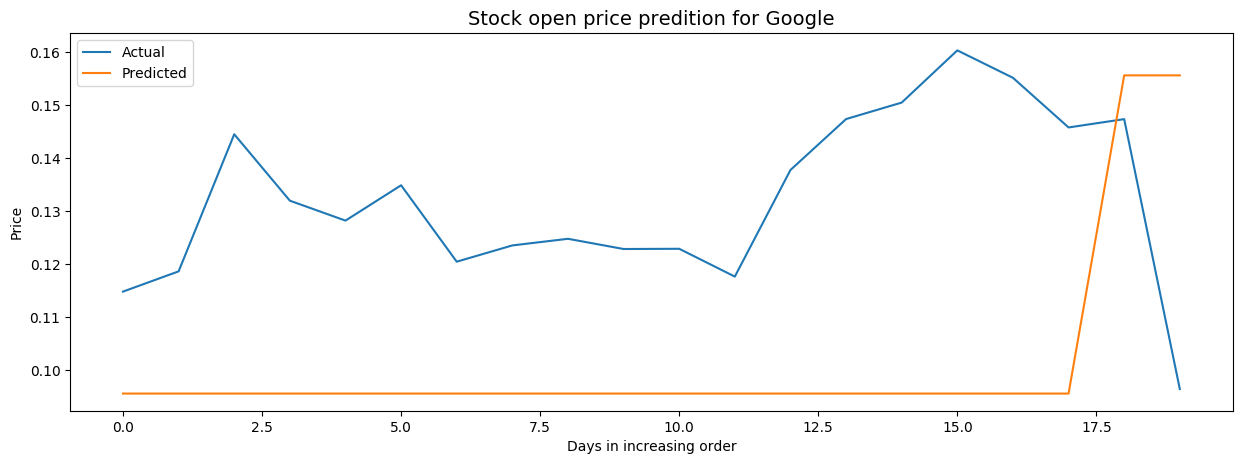


On Validation Data
[[0.1684565  0.50652694]
 [0.18419734 0.09562098]
 [0.3311862  0.45749085]
 [0.19355674 0.76397958]
 [0.35198334 0.15566803]
 [0.15193561 0.2210738 ]
 [0.23092692 0.63015373]
 [0.15090931 0.4391776 ]]


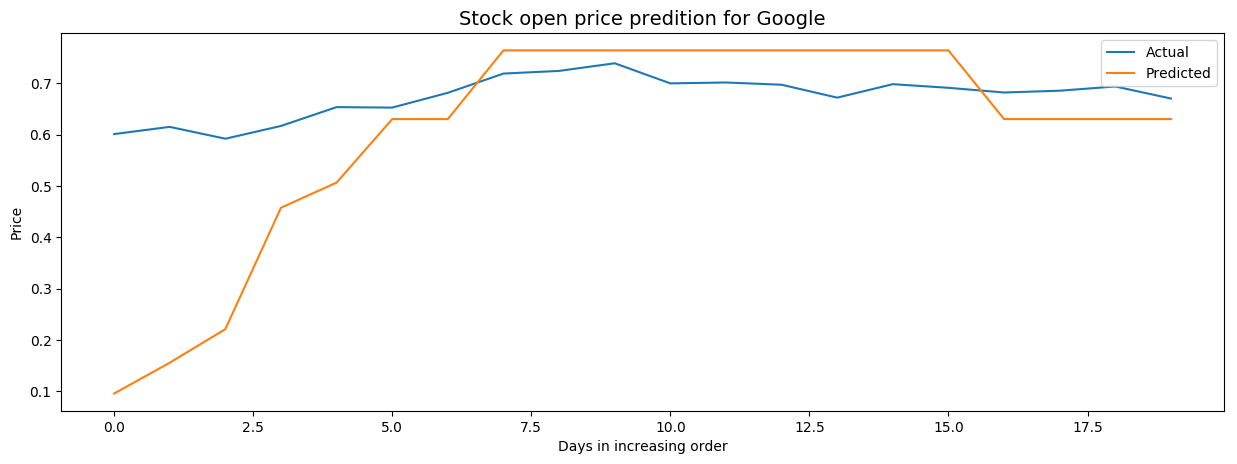



Model based on number of hidden states:  12  and time steps:  20

On Train Data
[[0.15719871 0.26187208]
 [0.11991444 0.60312165]
 [0.23248889 0.45848624]
 [0.32204539 0.15589655]
 [0.33958393 0.46114863]
 [0.43645272 0.14580322]
 [0.2417526  0.62677587]
 [0.19476267 0.09470663]
 [0.13267515 0.45247491]
 [0.15078425 0.1859139 ]
 [0.40563077 0.63040178]
 [0.20599267 0.76566126]]


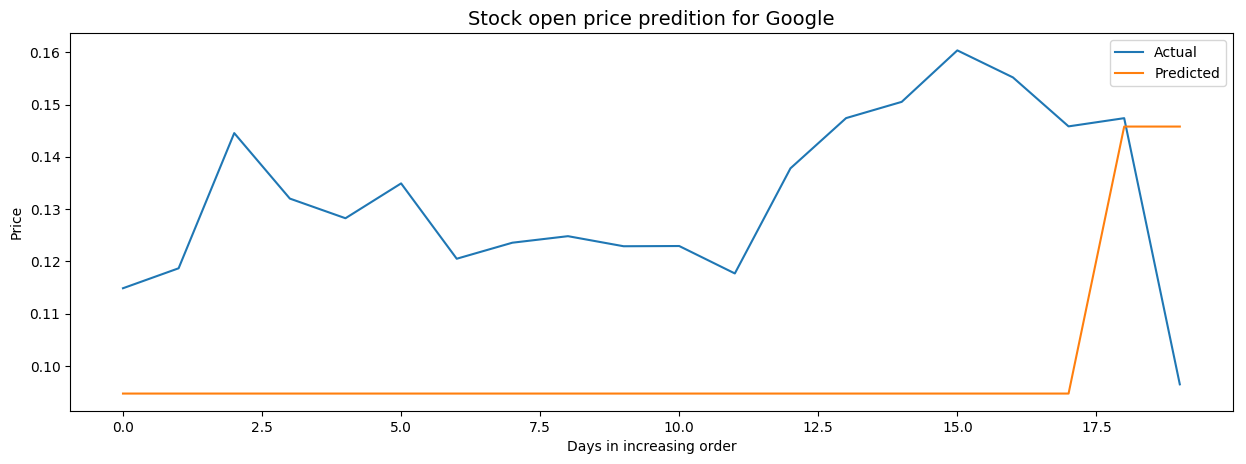


On Validation Data
[[0.15719871 0.26187208]
 [0.11991444 0.60312165]
 [0.23248889 0.45848624]
 [0.32204539 0.15589655]
 [0.33958393 0.46114863]
 [0.43645272 0.14580322]
 [0.2417526  0.62677587]
 [0.19476267 0.09470663]
 [0.13267515 0.45247491]
 [0.15078425 0.1859139 ]
 [0.40563077 0.63040178]
 [0.20599267 0.76566126]]


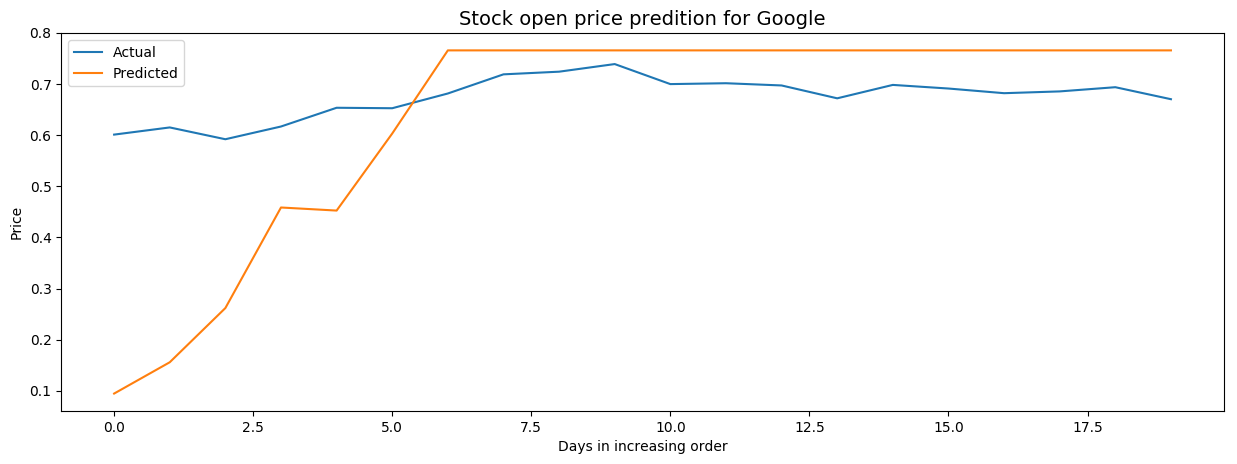



Model based on number of hidden states:  30  and time steps:  20

On Train Data
[[0.32984226 0.43701676]
 [0.12161941 0.18296578]
 [0.14120701 0.70719846]
 [0.3610472  0.07106898]
 [0.40971593 0.15720925]
 [0.14012524 0.50961334]
 [0.31006912 0.60973055]
 [0.22758163 0.5998704 ]
 [0.12834216 0.28014715]
 [0.1841102  0.43429445]
 [0.39268113 0.05876602]
 [0.14012597 0.50961435]
 [0.1201834  0.2205074 ]
 [0.33132499 0.64726322]
 [0.13897976 0.61506044]
 [0.21632008 0.064254  ]
 [0.28660349 0.44361552]
 [0.4119415  0.22898503]
 [0.38345916 0.16653651]
 [0.24975572 0.31284359]
 [0.16306338 0.10816458]
 [0.17116411 0.50865815]
 [0.50326942 0.50157961]
 [0.12732452 0.44618317]
 [0.19904335 0.79504531]
 [0.22457787 0.1678836 ]
 [0.12520025 0.22307228]
 [0.4430306  0.69852546]
 [0.23787116 0.23405087]
 [0.14470142 0.43922552]]


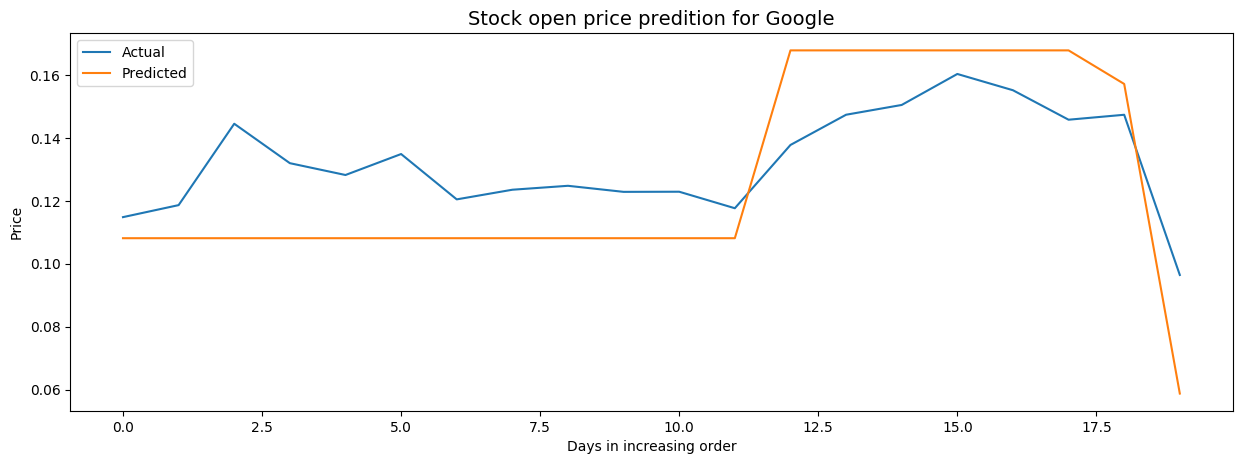


On Validation Data
[[0.32984226 0.43701676]
 [0.12161941 0.18296578]
 [0.14120701 0.70719846]
 [0.3610472  0.07106898]
 [0.40971593 0.15720925]
 [0.14012524 0.50961334]
 [0.31006912 0.60973055]
 [0.22758163 0.5998704 ]
 [0.12834216 0.28014715]
 [0.1841102  0.43429445]
 [0.39268113 0.05876602]
 [0.14012597 0.50961435]
 [0.1201834  0.2205074 ]
 [0.33132499 0.64726322]
 [0.13897976 0.61506044]
 [0.21632008 0.064254  ]
 [0.28660349 0.44361552]
 [0.4119415  0.22898503]
 [0.38345916 0.16653651]
 [0.24975572 0.31284359]
 [0.16306338 0.10816458]
 [0.17116411 0.50865815]
 [0.50326942 0.50157961]
 [0.12732452 0.44618317]
 [0.19904335 0.79504531]
 [0.22457787 0.1678836 ]
 [0.12520025 0.22307228]
 [0.4430306  0.69852546]
 [0.23787116 0.23405087]
 [0.14470142 0.43922552]]


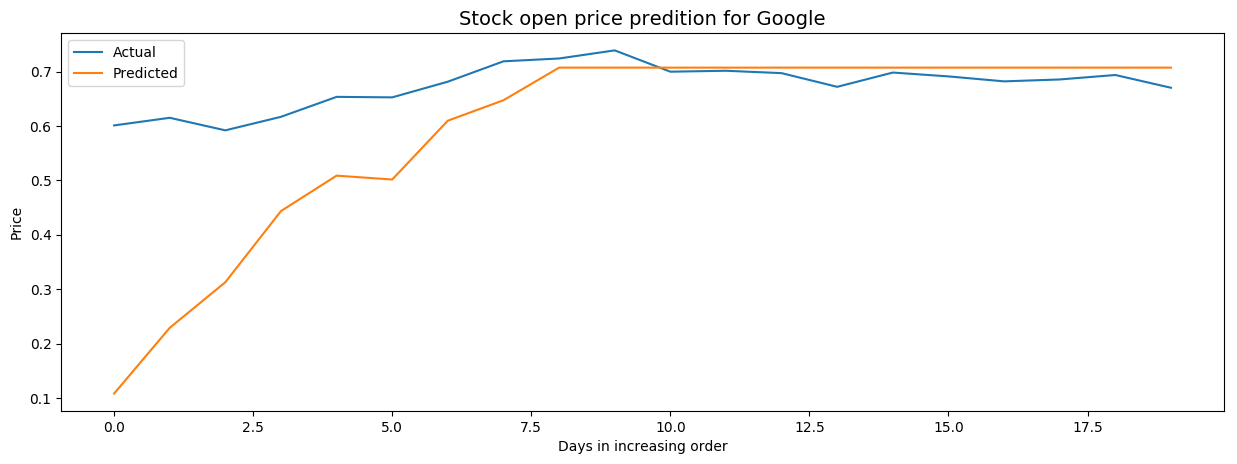



Model based on number of hidden states:  4  and time steps:  50

On Train Data
[[0.16753253 0.18748775]
 [0.18902427 0.67305496]
 [0.16643557 0.45887652]
 [0.3716929  0.33748709]]


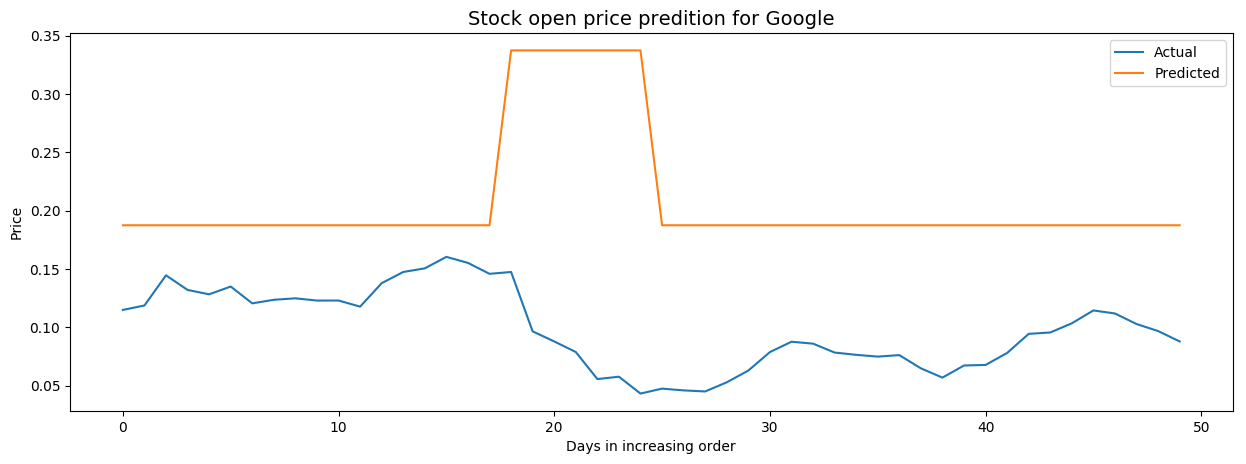


On Validation Data
[[0.16753253 0.18748775]
 [0.18902427 0.67305496]
 [0.16643557 0.45887652]
 [0.3716929  0.33748709]]


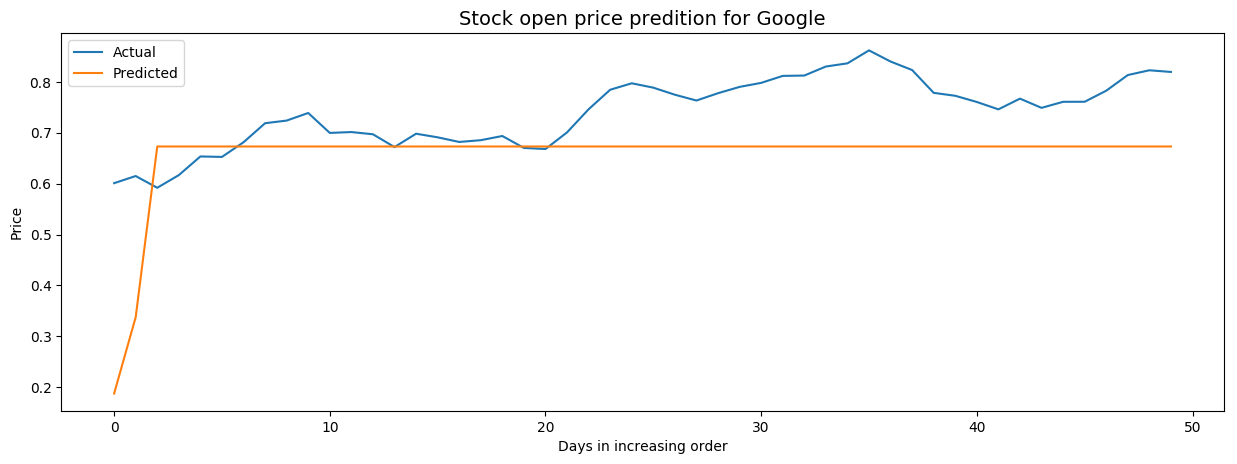



Model based on number of hidden states:  8  and time steps:  50

On Train Data
[[0.12860024 0.56387669]
 [0.15262526 0.2220009 ]
 [0.35218649 0.1555547 ]
 [0.25718852 0.55669547]
 [0.151473   0.44250963]
 [0.18420812 0.09561177]
 [0.37855415 0.55700546]
 [0.19749166 0.73174738]]


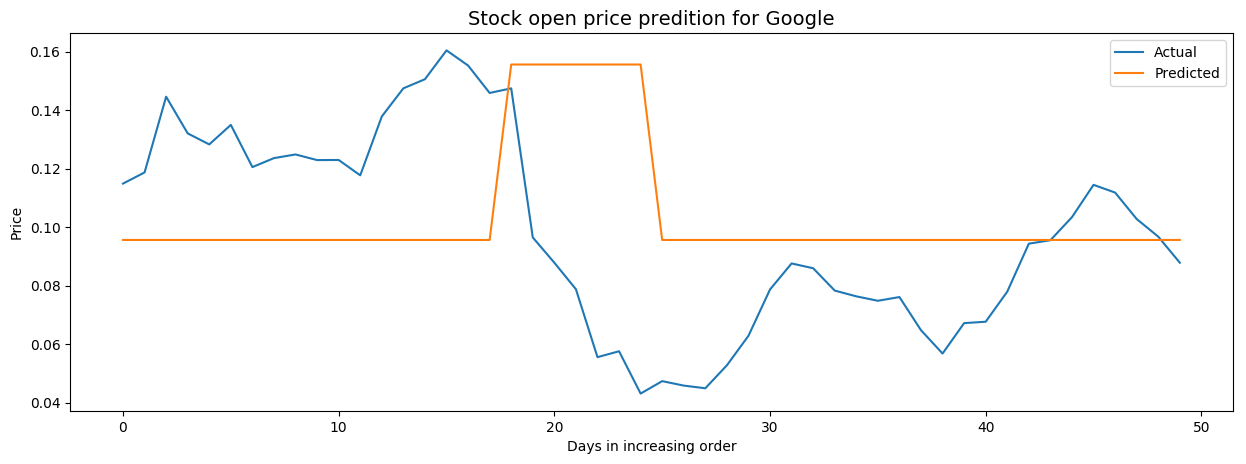


On Validation Data
[[0.12860024 0.56387669]
 [0.15262526 0.2220009 ]
 [0.35218649 0.1555547 ]
 [0.25718852 0.55669547]
 [0.151473   0.44250963]
 [0.18420812 0.09561177]
 [0.37855415 0.55700546]
 [0.19749166 0.73174738]]


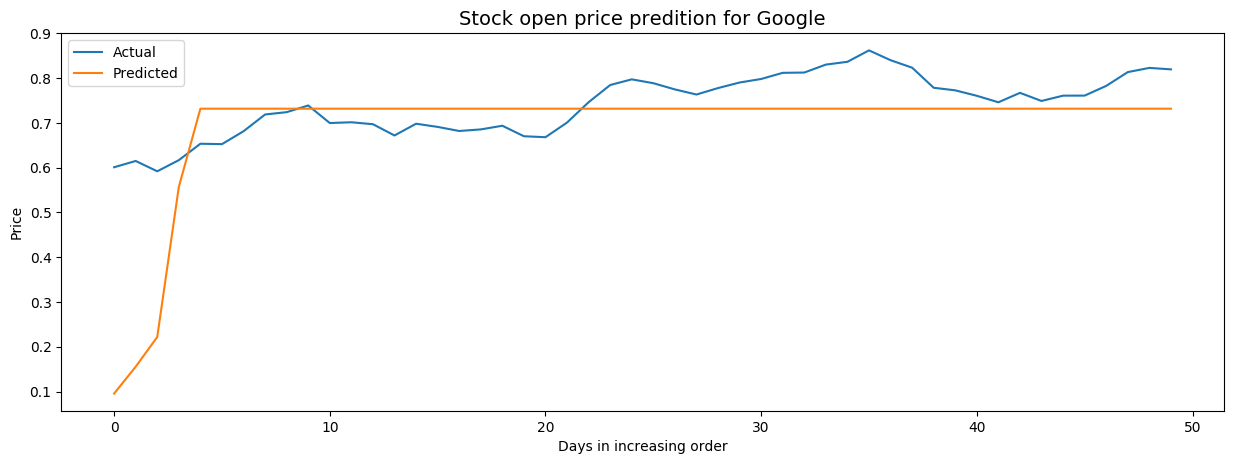



Model based on number of hidden states:  12  and time steps:  50

On Train Data
[[0.17744899 0.10576879]
 [0.23258166 0.45853941]
 [0.20590181 0.76567536]
 [0.27340916 0.0523169 ]
 [0.40508254 0.63036627]
 [0.23931686 0.62698918]
 [0.15934691 0.26375144]
 [0.3636596  0.18807194]
 [0.11917983 0.60262535]
 [0.13269834 0.45244444]
 [0.33957488 0.46120387]
 [0.15220768 0.18676041]]


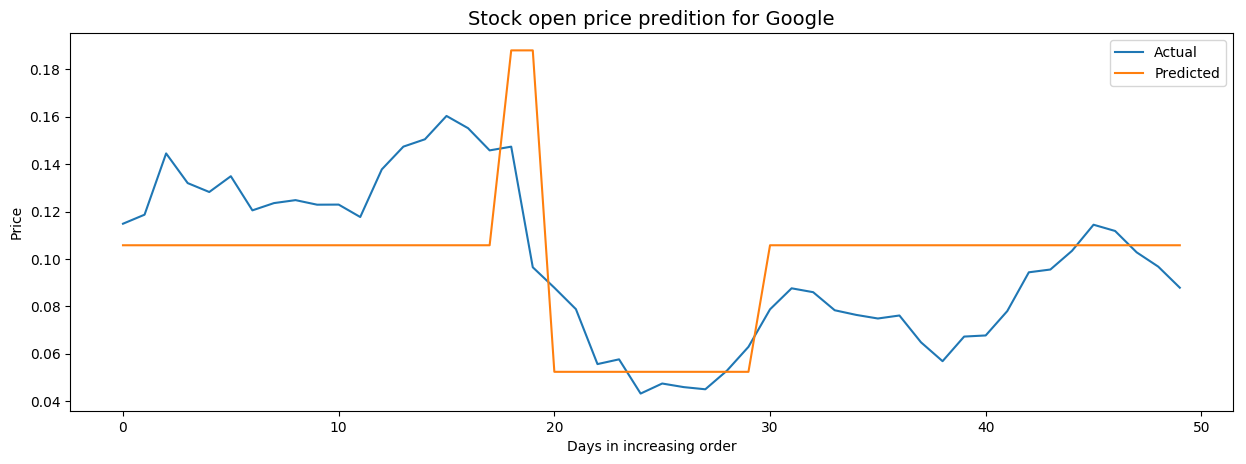


On Validation Data
[[0.17744899 0.10576879]
 [0.23258166 0.45853941]
 [0.20590181 0.76567536]
 [0.27340916 0.0523169 ]
 [0.40508254 0.63036627]
 [0.23931686 0.62698918]
 [0.15934691 0.26375144]
 [0.3636596  0.18807194]
 [0.11917983 0.60262535]
 [0.13269834 0.45244444]
 [0.33957488 0.46120387]
 [0.15220768 0.18676041]]


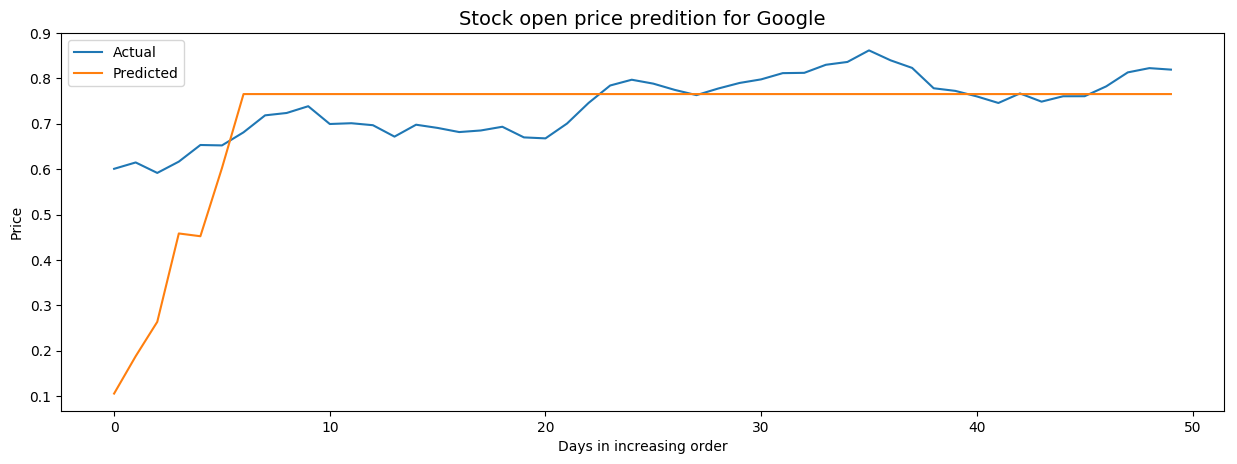



Model based on number of hidden states:  30  and time steps:  50

On Train Data
[[0.1412913  0.4377005 ]
 [0.24072943 0.23027663]
 [0.12605312 0.62401681]
 [0.36403081 0.64312716]
 [0.38338635 0.06248217]
 [0.12868749 0.28012729]
 [0.16364614 0.11219712]
 [0.50107058 0.50175076]
 [0.15406786 0.75833313]
 [0.33464454 0.05891429]
 [0.28654961 0.44480513]
 [0.21592348 0.1687856 ]
 [0.12148433 0.18296914]
 [0.30963141 0.61042161]
 [0.49226042 0.19259316]
 [0.36035014 0.44010749]
 [0.27312485 0.78635068]
 [0.17218125 0.50943481]
 [0.22395731 0.60111669]
 [0.1401054  0.51011154]
 [0.12524321 0.22308544]
 [0.34386472 0.08525068]
 [0.25618851 0.30727761]
 [0.19283565 0.06529394]
 [0.21509942 0.6877901 ]
 [0.23113834 0.17154397]
 [0.38346442 0.50196525]
 [0.80943196 0.66140016]
 [0.15640083 0.43952086]
 [0.49250754 0.21269101]]


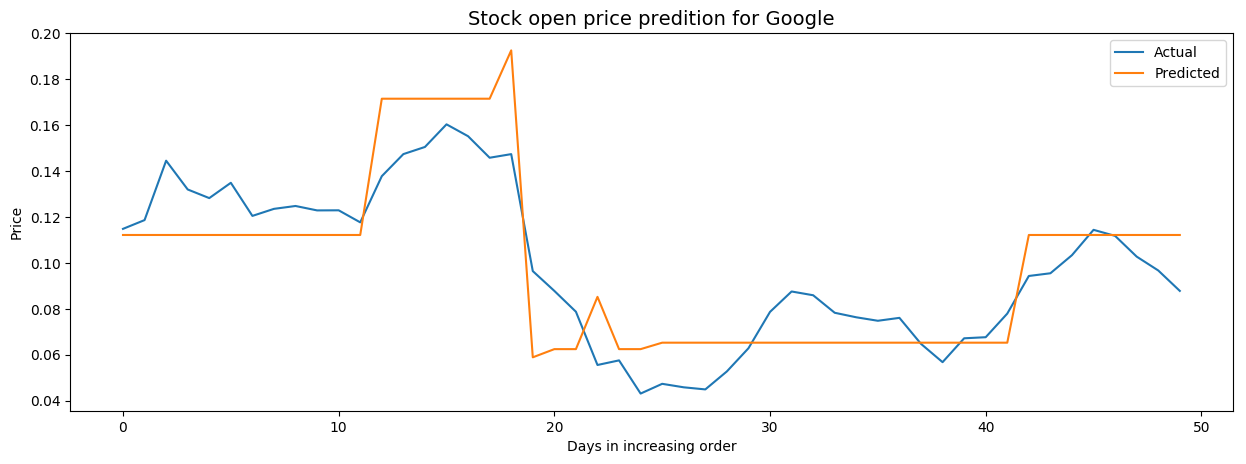


On Validation Data
[[0.1412913  0.4377005 ]
 [0.24072943 0.23027663]
 [0.12605312 0.62401681]
 [0.36403081 0.64312716]
 [0.38338635 0.06248217]
 [0.12868749 0.28012729]
 [0.16364614 0.11219712]
 [0.50107058 0.50175076]
 [0.15406786 0.75833313]
 [0.33464454 0.05891429]
 [0.28654961 0.44480513]
 [0.21592348 0.1687856 ]
 [0.12148433 0.18296914]
 [0.30963141 0.61042161]
 [0.49226042 0.19259316]
 [0.36035014 0.44010749]
 [0.27312485 0.78635068]
 [0.17218125 0.50943481]
 [0.22395731 0.60111669]
 [0.1401054  0.51011154]
 [0.12524321 0.22308544]
 [0.34386472 0.08525068]
 [0.25618851 0.30727761]
 [0.19283565 0.06529394]
 [0.21509942 0.6877901 ]
 [0.23113834 0.17154397]
 [0.38346442 0.50196525]
 [0.80943196 0.66140016]
 [0.15640083 0.43952086]
 [0.49250754 0.21269101]]


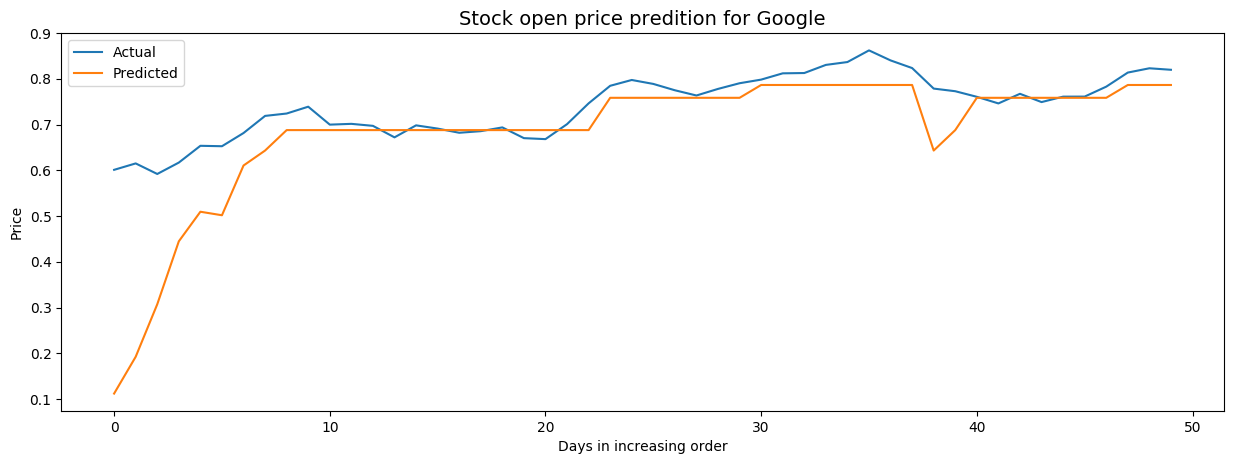



Model based on number of hidden states:  4  and time steps:  75

On Train Data
[[0.16753253 0.18748775]
 [0.18902427 0.67305496]
 [0.3716929  0.33748709]
 [0.16643557 0.45887652]]


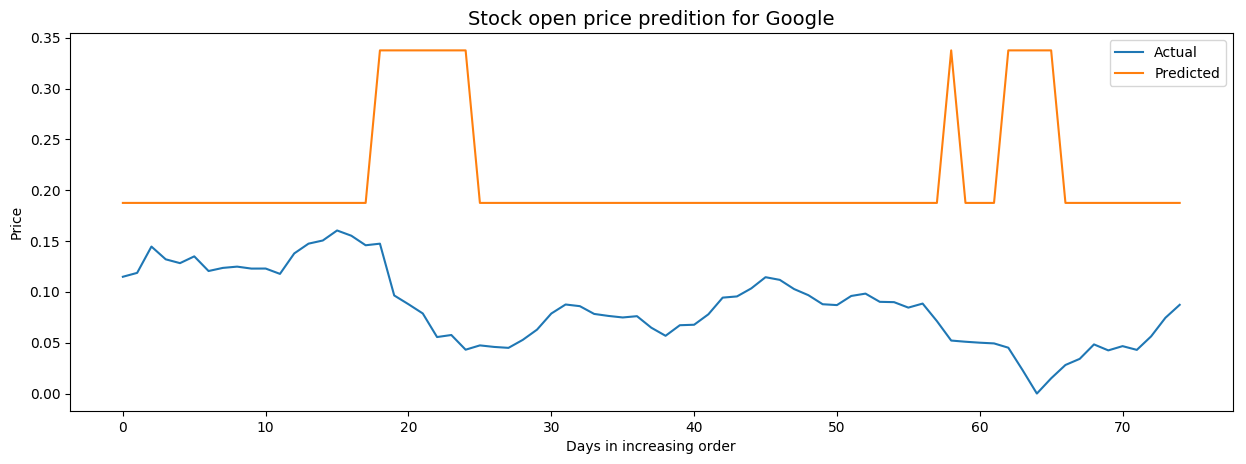


On Validation Data
[[0.16753253 0.18748775]
 [0.18902427 0.67305496]
 [0.3716929  0.33748709]
 [0.16643557 0.45887652]]


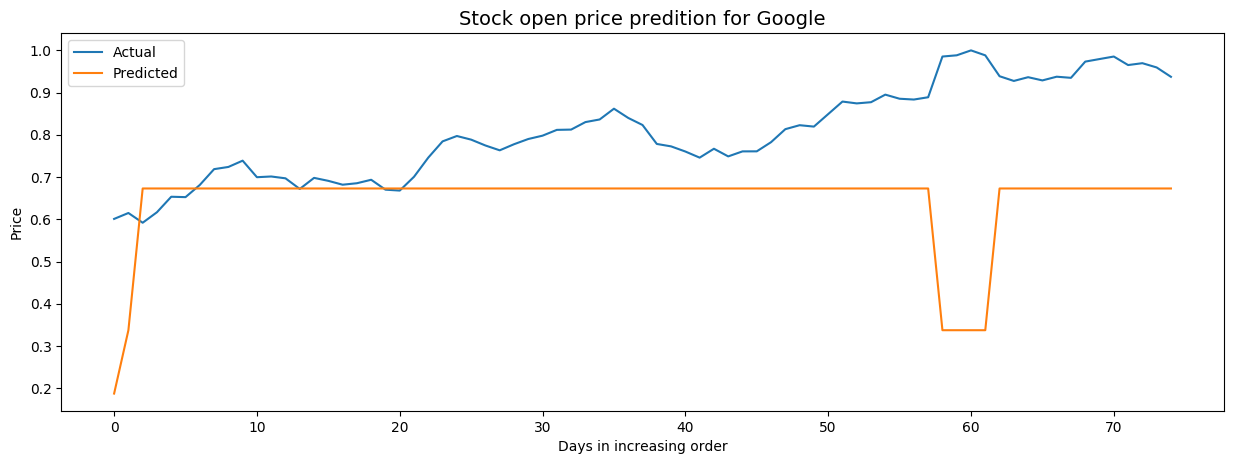



Model based on number of hidden states:  8  and time steps:  75

On Train Data
[[0.18420219 0.09562057]
 [0.16031505 0.59223398]
 [0.35662206 0.6399357 ]
 [0.15131964 0.22108861]
 [0.14643885 0.45272955]
 [0.35201908 0.15564837]
 [0.18825993 0.74149577]
 [0.26775324 0.46268514]]


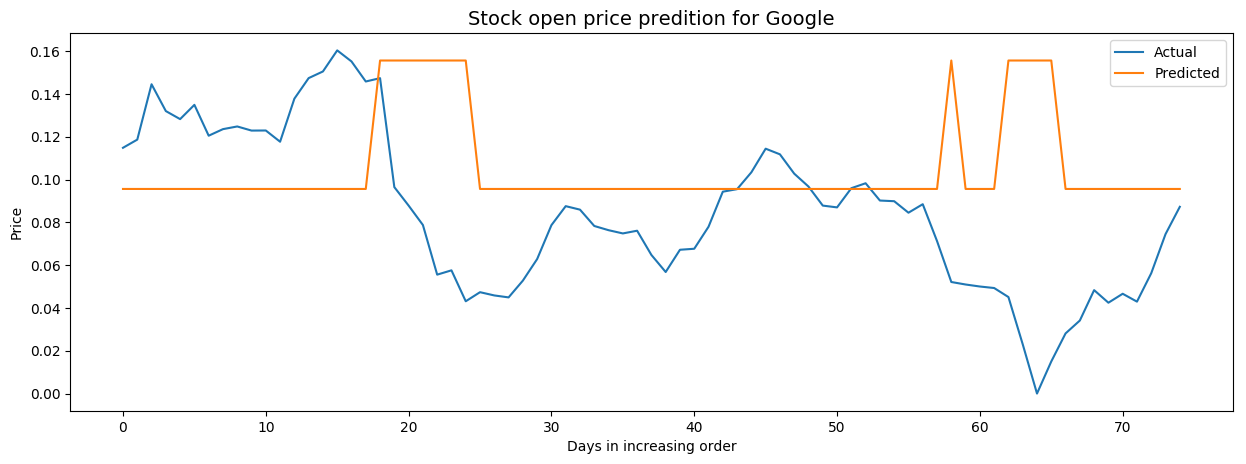


On Validation Data
[[0.18420219 0.09562057]
 [0.16031505 0.59223398]
 [0.35662206 0.6399357 ]
 [0.15131964 0.22108861]
 [0.14643885 0.45272955]
 [0.35201908 0.15564837]
 [0.18825993 0.74149577]
 [0.26775324 0.46268514]]


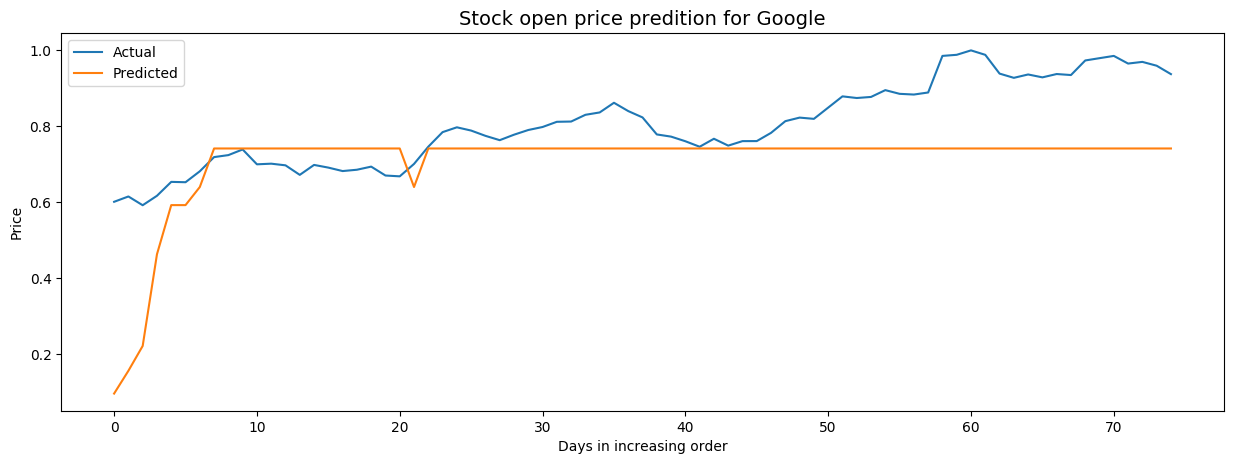



Model based on number of hidden states:  12  and time steps:  75

On Train Data
[[0.15187448 0.18582822]
 [0.20593598 0.765672  ]
 [0.33958333 0.4611529 ]
 [0.13267628 0.45245533]
 [0.38773681 0.15167158]
 [0.11950302 0.60283934]
 [0.23248145 0.45848863]
 [0.39190243 0.14168363]
 [0.18350494 0.09573755]
 [0.24031261 0.62691238]
 [0.15789717 0.26151993]
 [0.40533253 0.63038002]]


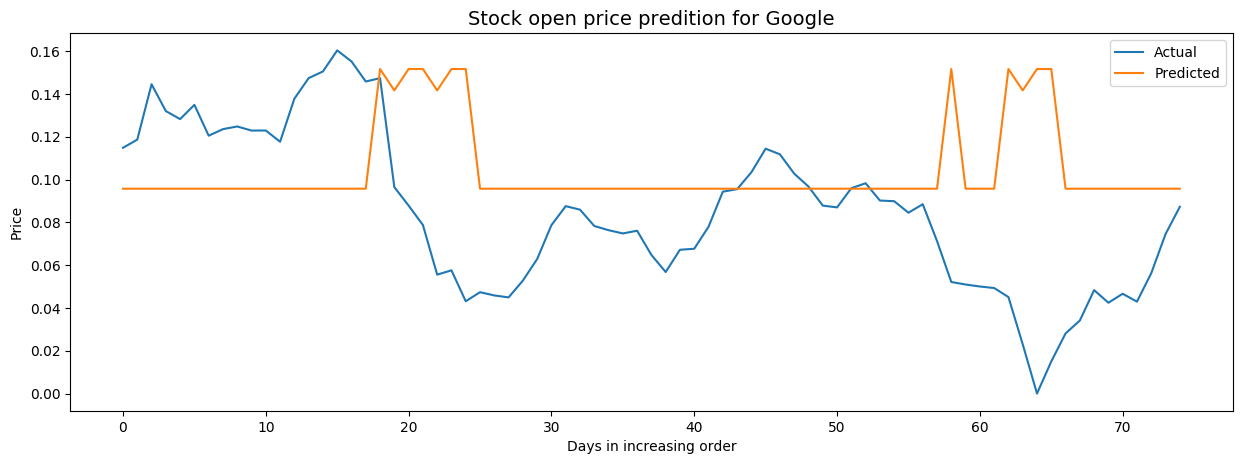


On Validation Data
[[0.15187448 0.18582822]
 [0.20593598 0.765672  ]
 [0.33958333 0.4611529 ]
 [0.13267628 0.45245533]
 [0.38773681 0.15167158]
 [0.11950302 0.60283934]
 [0.23248145 0.45848863]
 [0.39190243 0.14168363]
 [0.18350494 0.09573755]
 [0.24031261 0.62691238]
 [0.15789717 0.26151993]
 [0.40533253 0.63038002]]


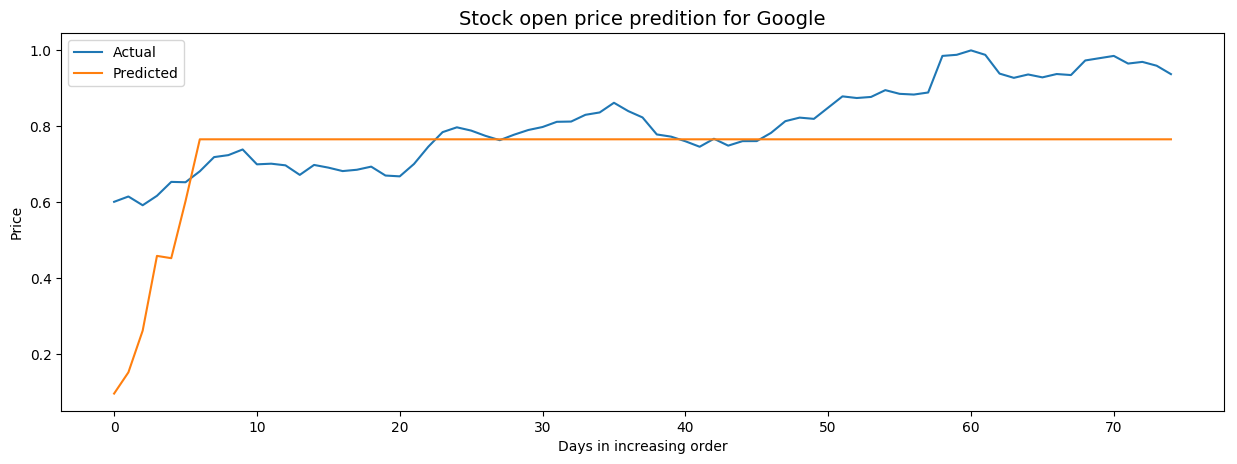



Model based on number of hidden states:  30  and time steps:  75

On Train Data
[[0.26165217 0.0531253 ]
 [0.26521734 0.42113664]
 [0.21448633 0.68768307]
 [0.1292497  0.18060478]
 [0.28167592 0.43718766]
 [0.14588712 0.2811456 ]
 [0.17120307 0.50859724]
 [0.24046126 0.17551213]
 [0.14016139 0.50961279]
 [0.39079482 0.09395153]
 [0.30969743 0.61042428]
 [0.12541784 0.22381074]
 [0.12614848 0.62389031]
 [0.25230865 0.04743296]
 [0.282071   0.16717672]
 [0.50280973 0.50156215]
 [0.23565309 0.23140972]
 [0.12048588 0.22131114]
 [0.13940218 0.4414333 ]
 [0.27313153 0.78635198]
 [0.15706472 0.43638795]
 [0.14016139 0.50961279]
 [0.18025647 0.09944509]
 [0.35980333 0.16425296]
 [0.22404235 0.60109477]
 [0.32486464 0.43081582]
 [0.15409346 0.75833936]
 [0.53238308 0.20094895]
 [0.53056478 0.44563424]
 [0.36384148 0.64312202]]


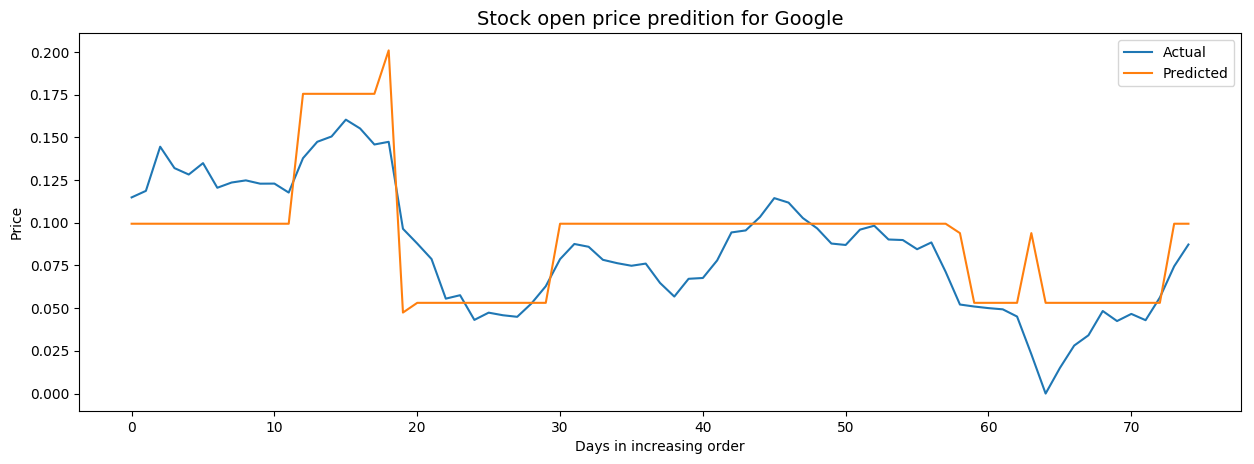


On Validation Data
[[0.26165217 0.0531253 ]
 [0.26521734 0.42113664]
 [0.21448633 0.68768307]
 [0.1292497  0.18060478]
 [0.28167592 0.43718766]
 [0.14588712 0.2811456 ]
 [0.17120307 0.50859724]
 [0.24046126 0.17551213]
 [0.14016139 0.50961279]
 [0.39079482 0.09395153]
 [0.30969743 0.61042428]
 [0.12541784 0.22381074]
 [0.12614848 0.62389031]
 [0.25230865 0.04743296]
 [0.282071   0.16717672]
 [0.50280973 0.50156215]
 [0.23565309 0.23140972]
 [0.12048588 0.22131114]
 [0.13940218 0.4414333 ]
 [0.27313153 0.78635198]
 [0.15706472 0.43638795]
 [0.14016139 0.50961279]
 [0.18025647 0.09944509]
 [0.35980333 0.16425296]
 [0.22404235 0.60109477]
 [0.32486464 0.43081582]
 [0.15409346 0.75833936]
 [0.53238308 0.20094895]
 [0.53056478 0.44563424]
 [0.36384148 0.64312202]]


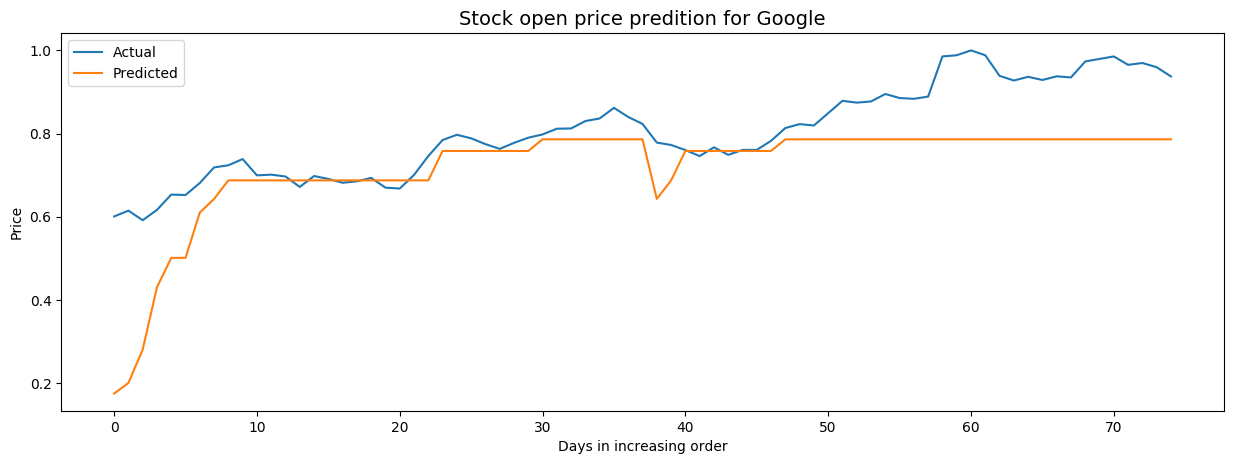

In [42]:
X, X_validation = data_preprocessing(isHMM = True)
n_steps_list = [20,50,75]
n_component = [4,8,12,30]
n_iterations = 1000
cov_type = "diag"
params = []

for i in n_steps_list:
    for j in n_component:
        print()
        print("Model based on number of hidden states: ",j," and time steps: ",i)
        print()
        params = [j,cov_type,n_iterations]
        model = train_model(X,params)
        print("On Train Data")
        prediction(model,X,i)
        print()
        print("On Validation Data")
        prediction(model,X_validation,i)
        print()

## Compare RNN and HMM Result

In [17]:
def compare_results():
    
    X_HMM, X_HMM_validation = data_preprocessing(isHMM = True)
    time_steps = 200
    n_component = 50
    n_iterations = 1000
    cov_type = "tied"

    print("HMM Model based on number of hidden states: ",n_component," and time steps: ",time_steps)
    print()
    params = [n_component,cov_type,n_iterations]
    model = train_model(X_HMM,params)
    # print("On Train Data")
    Y_train_HMM,Y_train_prediction_HMM = prediction(model,X_HMM,time_steps,return_prediction = True)
    print()
    # print("On Validation Data")
    Y_validation_HMM,Y_validation_prediction_HMM = prediction(model,X_HMM_validation,time_steps,return_prediction = True)

    num_steps = time_steps-1 
    num_inputs = 2
    num_neurons = 100 
    num_outputs = 2
    num_layers = 2
    learning_rate = 0.001
    num_epochs = 100

    hidden_layers = 3
    hidden_layer_size = 80

    df_RNN = data_preprocessing()
    X_train, Y_train, X_validation, Y_validation = train_validation_split(df,time_steps = time_steps,split_percentage = 0.2)

    params = [X_train, Y_train, X_validation, Y_validation, num_steps,num_inputs,num_neurons,num_outputs,num_layers,learning_rate,num_epochs]

    Y_train_prediction_RNN,Y_validation_prediction_RNN = train_evaluate_model(params)


    x_length = time_steps
    start = Y_train.shape[0] - time_steps
    
    
    Y_train_prediction_HMM = MinMaxScaler().fit_transform(np.array(Y_train_prediction_HMM).reshape(-1,1))
    Y_validation_prediction_HMM = MinMaxScaler().fit_transform(np.array(Y_validation_prediction_HMM).reshape(-1,1))
    
    plt.figure(figsize=(15, 5), dpi=100)
    plt.plot(np.arange(x_length), Y_train[start:,1], color='blue', label='Train Target')
    plt.plot(np.arange(x_length), Y_train_prediction_RNN[start:,1],color='green', label='Train Prediction using RNN')
    plt.plot(np.arange(x_length), Y_train_prediction_HMM,color='red', label='Train Prediction using HMM')

    plt.title('Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Price (normalized)')
    plt.legend(loc='best')
    plt.show()
    plt.close()
    
    
#     print(Y_validation.shape)
#     print(Y_validation_prediction_HMM.shape)

    x_length = Y_validation.shape[0]    
    
    index = Y_validation_prediction_HMM.shape[0] - Y_validation.shape[0] 
    
    plt.figure(figsize=(15, 5), dpi=100)
    plt.plot(np.arange(x_length), Y_validation[:,1], color='blue', label='Validation Target')
    plt.plot(np.arange(x_length), Y_validation_prediction_RNN[:,1],color='green', label='Validation Prediction using RNN')
    plt.plot(np.arange(x_length), Y_validation_prediction_HMM[index:],color='red', label='Validation Prediction using HMM')

    plt.title('Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Price (normalized)')
    plt.legend(loc='best')
    plt.show()
    plt.close()

HMM Model based on number of hidden states:  50  and time steps:  200




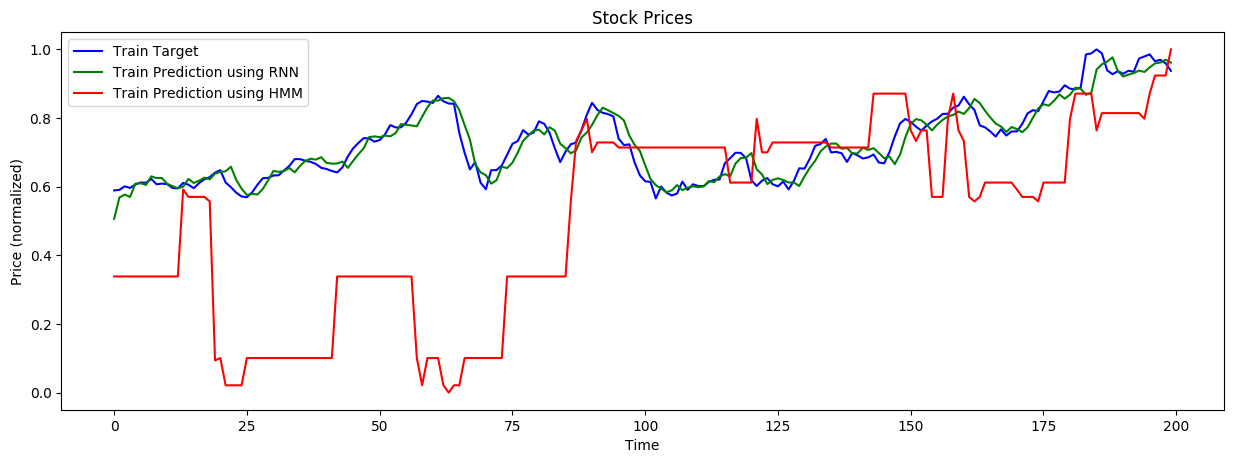

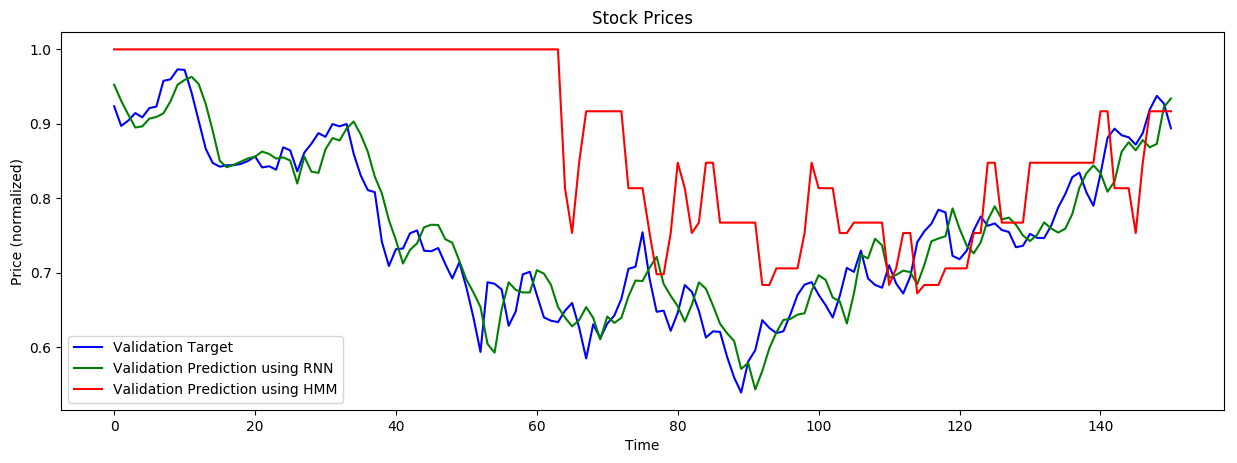

In [18]:
compare_results()